In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path
import yaml
import re

import pyarrow as pa
import pyarrow.parquet as pq

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

import vivarium_helpers as vh
import vivarium_helpers.id_helper as idh
from vivarium_helpers.vph_output.operations import VPHOperator
from vivarium_helpers.vph_output import cleaning

!date
!whoami
!pwd

Thu Oct 23 17:08:40 PDT 2025
ndbs
/mnt/share/code/ndbs/vivarium_research_alzheimers/verification_and_validation


# Record versions of Vivarium libraries

In [3]:
!pip list | grep vivarium

vivarium                                 3.4.12
vivarium_build_utils                     2.0.4
vivarium_cluster_tools                   2.1.17
vivarium_csu_alzheimers                  0.1.dev18+g43e997c.d20250808 /mnt/share/code/ndbs/vivarium_csu_alzheimers
vivarium_dependencies                    1.0.1
vivarium_gbd_access                      4.2.4
vivarium_helpers                         0.2.0                        /mnt/share/code/ndbs/vivarium_helpers/src
vivarium_inputs                          6.0.4
vivarium_public_health                   4.3.5


In [4]:
!pip freeze | grep vivarium

vivarium==3.4.12
vivarium_build_utils==2.0.4
vivarium_cluster_tools==2.1.17
-e git+https://github.com/ihmeuw/vivarium_csu_alzheimers.git@c7315b0703d0e097dce6e7600f2ac2846d4a4e31#egg=vivarium_csu_alzheimers
vivarium_dependencies==1.0.1
vivarium_gbd_access==4.2.4
-e git+https://github.com/ihmeuw/vivarium_helpers.git@2da907bde9e9a9ee21cd854a41d5ce01674c6c5b#egg=vivarium_helpers
vivarium_inputs==6.0.4
vivarium_public_health==4.3.5


# V&V List


1. Positive BBBM tests result in treatment initiation rates that match
    the year/location specific rates from in the [treatment intervention
    data table](https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/alzheimers/hypothetical_treatment.html#alzheimers-intervention-treatment-data-table)

1. 10% of transitions to Full treatment effect status are by simulants who discontinue treatment

1. Full/Waning durations are accurate (use person-time ratios between states?)

1. “In treatment/waiting for treatment” duration is accurate (use person-time ratios between states?)

1.  Interactive sim verification spot checking a simulant’s durations in
    treatment statuses as they move through BBBM test negative, Full
    treatment effect, Waning treatment effect, No treatment effect
    statuses (for both completed and discontinued treatments)

1.  Check hazard ratios for simulants who begin treatment and those who
    transition to *No treatment effect* (Check hazard ratio of treated to
    not treated for hazard rate from BBBM to MCI)

Time- and location-specific treatment initiation rate from treatment
intervention data table:

> Lilly: “The percent of patients with a positive BBBM test who initiate treatment will vary by location and over time – but will not vary by age or sex. In the US: 30% of eligible patients initiate (constant 2030-2100); Japan: 80% of eligible patients initiate (constant 2030-2100); all other countries: 40% of eligible patients initiate in 2030, increasing linearly to 70% by 2035, remaining constant at 70% until 2100.””

# Find data

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model7.0/model_spec/2025_10_09_17_56_46/results

In [5]:
# Project directory
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [6]:
# Results directory containing model 7 results for all locations
results_subdir = 'results/model7.1/model_spec/2025_10_21_12_50_29/'
!ls -halt $results_subdir/results

total 132M
drwxrwsr-x 5 albrja IHME-Simulationscience 4.5K Oct 21 15:02 ..
drwxrwsr-x 2 albrja IHME-Simulationscience 6.5K Oct 21 15:01 .
-rw-rw-r-- 1 albrja IHME-Simulationscience 4.4M Oct 21 15:01 counts_baseline_tests_among_eligible.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience  13M Oct 21 15:01 person_time_treatment.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience 2.5M Oct 21 15:01 transition_count_treatment.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience  38M Oct 21 15:01 ylds.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience 1.3M Oct 21 15:01 counts_newly_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience  13M Oct 21 15:01 transition_count_alzheimers_disease_and_other_dementias.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience 1.2M Oct 21 15:00 person_time_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience 8.3M Oct 21 15:00 person_time_ever_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience 

In [7]:
!ls results/model7.0/model_spec/2025_10_09_17_56_46/

__pycache__		   keyspace.yaml	     requirements.txt
branches.yaml		   logs			     results
finished_sim_metadata.csv  model_specification.yaml  settings.py


In [8]:
locations = [
    'United States of America',
    # 'Brazil',
    # 'China',
    # 'Germany',
    # 'Israel',
    # 'Japan',
    'Spain',
    # 'Sweden',
    # 'Taiwan (Province of China)',
    # 'United Kingdom',
]

# Define some shorter names to use for plotting
location_to_short_name = ({loc: loc for loc in locations} | {
    'Taiwan (Province of China)': 'Taiwan',
    'United Kingdom': 'UK',
    'United States of America': 'USA',
})

# # Select a subset of locations to draw plots for
# locations_to_plot = locations[:2]

project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

artifact_model_number = '7.0' # Artifacts are stored here
run_subdirectories = [
    results_subdir,
]
run_dirs = [project_dir + run_subdir for run_subdir in run_subdirectories]
results_dirs = [run_dir + 'results/' for run_dir in run_dirs]

# # Option 1: One results directory per location
# location_to_results_dir = {
#     loc: path for loc, path in zip(locations, results_dirs)}

# Option 2: All locations in one results directory
location_to_results_dir = {'all': results_dirs[0]}

location_to_artifact_subdir = {loc: loc.lower().replace(' ', '_') for loc in locations}
artifact_subpaths = [f'artifacts/model{artifact_model_number}/' + subdir + '.hdf' for subdir in location_to_artifact_subdir.values()]
location_to_artifact_path = {loc: project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
location_to_artifact_path

{'United States of America': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf',
 'Spain': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/spain.hdf'}

In [9]:
location_to_results_dir

{'all': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model7.1/model_spec/2025_10_21_12_50_29/results/'}

# Define some ordered Categorical dtypes, and convert years to ints

In [10]:
# Order locations lexicographically
all_locations = [
    'United States of America',
    'Brazil',
    'China',
    'Germany',
    'Israel',
    'Japan',
    'Spain',
    'Sweden',
    'Taiwan (Province of China)',
    'United Kingdom',
]
location_dtype = pd.CategoricalDtype(sorted(all_locations), ordered=True)

# Order years chronologically (for some reason years are strings in the output)
# years = [str(year) for year in range(2025, 2101)]
# year_dtype = pd.CategoricalDtype(years, ordered=True)
# int16 ranges from -32768 to 32767 (I think), which is sufficient to
# represent all years 2025-2100. uint8 only goes from 0 to 255, which is
# too small.
year_dtype = 'int16'

# Order age groups chronologically
age_groups = [f'{age}_to_{age + 4}' for age in range(25, 95, 5)] + ['95_plus']
age_group_dtype = pd.CategoricalDtype(age_groups, ordered=True)

# Order scenarios by complexity
scenarios = ['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
scenario_dtype = pd.CategoricalDtype(scenarios, ordered=True)

colname_to_dtype = {
    'location': location_dtype,
    'event_year': year_dtype,
    'age_group': age_group_dtype,
    'scenario': scenario_dtype,
}

# Load one artifact and define age bins

In [11]:
artifact_path = location_to_artifact_path[locations[0]]
art = Artifact(artifact_path)
print(art.load('metadata.locations'))
print(art)

['United States of America']
Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		cause_specific_mortality_rate
		excess_mortality_rate
		disability_weight
		restrictions
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet
treatment
	relative_risk



In [12]:
# age_bins is an empty DataFrame with a MultiIndex storing age group data
age_bins = art.load('population.age_bins')
age_dictionary = (
    age_bins
    .reset_index()
    .assign(age_group=lambda df: df['age_group_name'].str.replace(' ', '_'))
    # Filter to ages that actually appear in our sim
    .query("age_start >= 25")
)
age_dictionary

age_group_id age_group_name  age_start  age_end age_group
4             10       25 to 29       25.0     30.0  25_to_29
5             11       30 to 34       30.0     35.0  30_to_34
6             12       35 to 39       35.0     40.0  35_to_39
7             13       40 to 44       40.0     45.0  40_to_44
8             14       45 to 49       45.0     50.0  45_to_49
9             15       50 to 54       50.0     55.0  50_to_54
10            16       55 to 59       55.0     60.0  55_to_59
11            17       60 to 64       60.0     65.0  60_to_64
12            18       65 to 69       65.0     70.0  65_to_69
13            19       70 to 74       70.0     75.0  70_to_74
14            20       75 to 79       75.0     80.0  75_to_79
15            30       80 to 84       80.0     85.0  80_to_84
16            31       85 to 89       85.0     90.0  85_to_89
17            32       90 to 94       90.0     95.0  90_to_94
18           235        95 plus       95.0    125.0   95_plus

# See what the treatment relative risk looks like

Draws should be uniformly distributed in $[0.4, 0.6]$.

In [13]:
treatment_rr = art.load('treatment.relative_risk')
treatment_rr

draw_0    draw_1    draw_2    draw_3    draw_4    draw_5    draw_6  \
0  0.527516  0.495529  0.464333  0.576056  0.478925  0.458396  0.541982   

     draw_7   draw_8    draw_9  ...  draw_490  draw_491  draw_492  draw_493  \
0  0.520483  0.53923  0.514836  ...  0.485136  0.498684  0.503797  0.432717   

   draw_494  draw_495  draw_496  draw_497  draw_498  draw_499  
0  0.462276  0.481699  0.569136  0.502568    0.4362  0.512734  

[1 rows x 500 columns]

# Define functions to load and merge Artifact data from all locations, and to summarize Artifact data for plotting

In [14]:
def load_artifact_data(
    key,
    filter_terms=None,
    location_to_artifact_path=location_to_artifact_path,
):
    dfs = {} # dict to map locations to artifact data
    for location, path in location_to_artifact_path.items():
        art = Artifact(path, filter_terms)
        # Check to make sure location matches artifact
        art_locations = art.load('metadata.locations')
        assert len(art_locations) == 1 and art_locations[0] == location, \
            f'Unexpected locations in artifact: {location=}, {art_locations=}'
        df = art.load(key)
        dfs[location] = df
    data = pd.concat(dfs, names=['location', *df.index.names])
    return data

def lower(x):
    return x.quantile(0.025)

def upper(x):
    return x.quantile(0.975)

def summarize_artifact_data(df):
    summary = df.agg(['mean', lower, upper], axis='columns')
    return summary

# Define functions to load simulation output and summarize it for plotting

With the `pyarrow` engine, `pandas.read_parquet()` calls `pyarrow.parquet.read_table()` and
`pyarrow.Table.to_pandas()`. Additional keyword arguments passed to
`pandas.read_parquet()` are passed to `pyarrow.parquet.read_table()`.

https://arrow.apache.org/docs/python/generated/pyarrow.parquet.read_table.html#pyarrow.parquet.read_table

https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.to_pandas

Pyarrow Dictionary arrays are analogous to pandas Categoricals:

https://arrow.apache.org/docs/python/data.html#data-dictionary

Pyarrow data types:

https://arrow.apache.org/docs/python/api/datatypes.html

https://arrow.apache.org/docs/python/generated/pyarrow.types.is_floating.html


Google AI results for "find column names in parquet file":

```python
import pyarrow.parquet as pq

# Replace 'your_file.parquet' with the actual path to your Parquet file
parquet_file_path = 'your_file.parquet'

# Read the Parquet file's schema
parquet_schema = pq.read_schema(parquet_file_path)

# Extract column names
column_names = parquet_schema.names

print(f"Column names in '{parquet_file_path}':")
for name in column_names:
    print(name)
```

In [15]:
# Create an operator object
ops = VPHOperator()
ops.index_cols.append('location')

def load_sim_output(
        measure,
        results_dict=location_to_results_dir,
        # Pass None to skip filtering locations (when None, must also
        # pass assign_location=False or raw=True)
        location_to_artifact_path=location_to_artifact_path,
        colname_to_dtype=colname_to_dtype,
        drop_superfluous_cols=True, # drop redundant or empty columns
        # Sets the 'read_dictionary' key of kwargs, which is passed to
        # pyarrow.parquet.read_table()
        force_parquet_dictionaries=True,
        force_pandas_categoricals=True,
        aggregate_seeds=True,
        assign_location=True,
        raw=False, # Overrides other parameters if True
        **kwargs, # keyword args to pass to .read_parquet
    ):
    """Load simulation output from .parquet files for all locations,
    optionally reducing the size of the data when possible. Returns
    concatenated outputs with a 'location' column added.
    """
    if raw:
        drop_superfluous_cols = False
        force_parquet_dictionaries = False
        force_pandas_categoricals = False
        aggregate_seeds = False
        assign_location = False

    match location_to_results_dir:
        case {'all': _}:
            all_locations_together = True
        case _:
            all_locations_together = False
    
    if all_locations_together and assign_location and location_to_artifact_path is None:
        raise ValueError(
            "Must provide mapping of artifacts to locations  when" \
            " assign_location=True and all locations are in a single" \
            " results directory"
        )

    dfs = []
    for location, directory in results_dict.items():

        parquet_file_path = Path(directory) / f'{measure}.parquet'
        # Read the Parquet file's schema to get column names and data types
        parquet_schema = pq.read_schema(parquet_file_path)

        if (
            all_locations_together
            and location_to_artifact_path is not None
        ):
            if 'artifact_path' in parquet_schema.names:
                # Filter to locations in list
                location_filter = (
                    'artifact_path',
                    'in',
                    list(location_to_artifact_path.values()),
                )
                user_filters = kwargs.get('filters') # Defaults to None
                kwargs['filters'] = add_parquet_AND_filter(
                    location_filter, user_filters)
            else:
                print("'artifact_path' column missing from parquet file."
                      " Not filtering locations.")
        
        print(location_filter)

        if force_parquet_dictionaries:
            # Read all columns as dictionaries except those containing 
            # floating point values
            kwargs['read_dictionary'] = [
                col.name for col in parquet_schema
                if not pa.types.is_floating(col.type)]

        # Read the parquet file
        df = pd.read_parquet(parquet_file_path, **kwargs)

        if drop_superfluous_cols:
            # Drop redundant columns
            for col1, col2 in [
                ('input_draw', 'input_draw_number'),
                ('entity', 'sub_entity'),
            ]:
                if (col1 in df and col2 in df and df[col1].equals(df[col2])):
                    df.drop(columns=col2, inplace=True)
            # Drop empty columns (e.g., sub-entity)
            for col in df:
                if df[col].isna().all():
                    df.drop(columns=col, inplace=True)
        if colname_to_dtype is not None:
            convert_dtypes(df, colname_to_dtype, inplace=True)
        if force_pandas_categoricals:
            convert_to_categorical(
                df, exclude_cols=colname_to_dtype or (), inplace=True)
        if aggregate_seeds:
            # Use default index and value columns when aggregating
            df = vh.vph_output.operations.marginalize(df, 'random_seed')
        if assign_location:
            if all_locations_together:
                # Invert the dictionary so we can map artifact paths to
                # locations
                # NOTE: Guaranteed not to be None because
                # assign_location is True
                artifact_path_to_location = {
                    path: loc for loc, path in location_to_artifact_path.items()}
                if 'artifact_path' in df:
                    df['location'] = df['artifact_path'].map(
                        artifact_path_to_location).astype(location_dtype)
                else:
                    # In case the engineers change the DataFrame format
                    # on us...
                    print("'artifact_path' column missing from DataFrame."
                          " Not assigning locations.")
            else:
                df['location'] = location
                df['location'] = df['location'].astype(location_dtype)
        dfs.append(df)
    df = pd.concat(dfs)
    return df

def convert_dtypes(df, colname_to_dtype, inplace=False):
    if not inplace:
        df = df.copy()
    for colname, dtype in colname_to_dtype.items():
        if colname in df:
            df[colname] = df[colname].astype(dtype)

    if not inplace:
        return df
    else:
        return None

# TODO: Consider making certain columns ordered Categoricals
def convert_to_categorical(
        df,
        include_cols=(),
        exclude_cols=(),
        exclude_dtypes=('float', 'category'),
        inplace=False
    ):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if  len(set(include_cols).intersection(exclude_cols)) != 0:
        raise ValueError("A column can't be both included and excluded!")
    if not inplace:
        df = df.copy()
    for col in df:
        if (
            col in include_cols
            or (col not in exclude_cols 
                and df[col].dtype not in exclude_dtypes)
        ):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None
    
def add_parquet_AND_filter(new_filter, existing_filters):
    match existing_filters:
        case None:
            # No existing filters -- create a single AND group
            filters = [new_filter]
        case list([tuple((_, _, _)), *_]):
            # Existing filters consist of one AND group -- add the new filter
            filters = [new_filter, *existing_filters]
        case list([list([tuple((_, _, _)), *_]), *_]):
            # Add the filter to each AND group in the outer OR group
            filters = [[new_filter, *and_group] for and_group in existing_filters]
        case _:
            raise ValueError(f"Malformed parquet filter: {existing_filters}")
    # # Alternate version using isinstance()
    # if existing_filters is None:
    #     # No existing filters -- create a single AND group
    #     filters = [new_filter]
    # elif isinstance(existing_filters[0], tuple):
    #     # Existing filters consist of one AND group -- add the new filter
    #     filters = [new_filter, *existing_filters]
    # elif isinstance(existing_filters[0], list):
    #     # Add the filter to each AND group in the outer OR group
    #     filters = [[new_filter, *and_group] for and_group in existing_filters]
    # else:
    #     raise ValueError(f"Malformed parquet filter: {existing_filters}")
    return filters

# NOTE: Need to create ops before defining this function
def summarize_sim_data(df, age_dictionary=age_dictionary):
    """Summarize simulation data for plotting."""
    # Merge to get an age_start column for plotting
    if 'age_group' in df:
        df = df.merge(age_dictionary, on='age_group')
    # Summarize, and rename percentiles to match artifact
    summary = ops.describe(df).rename(
        columns={'2.5%': 'lower', '97.5%': 'upper'})
    return summary

def print_memory_usage(df):
    print(df.memory_usage(deep=True).sum() / 1e6, 'MB')


# Test code for loading sim output

In [16]:
new_sims = load_sim_output(
    'counts_new_simulants',
    # colname_to_dtype=None,
    # raw=True,
    engine='pyarrow',
    # read_dictionary=['input_draw', 'scenario'],
    # filters=[('event_year', '==', '2025')],
    # assign_location=False,
)
new_sims

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/spain.hdf'])


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
341995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
341996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
341997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
341998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
341999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

        event_year input_draw                    scenario     sex  value  \
0             2025        113                    baseline  Female    1.0   
1             2025        113                    baseline    Male    0.0   
2             2025        113                bbbm_testing  Female    1.0   
3             2025        113                bbbm_testing    Male    0.0   
4             2025        113  bbbm_testing_and_treatment  Female    1.0   
...            ...        ...                         ...     ...    ...   
341995        2100        457                    baseline    Male    0.0   
341996        2100        457                bbbm_testing  Female    0.0   
341997        2100        457                bbbm_testing    Male    0.0   
341998        2100        457  bbbm_testing_and_treatment  Female    0.0   
341999        2100        457  bbbm_testing_and_treatment    Male    0.0   

                        location  
0                          Spain  
1                          Spain  
2                          Spain  
3                          Spain  
4                          Spain  
...                          ...  
341995  United States of America  
341996  United States of America  
341997  United States of America  
341998  United States of America  
341999  United States of America  

[342000 rows x 8 columns]

In [17]:
new_sims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342000 entries, 0 to 341999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   age_group      342000 non-null  category
 1   artifact_path  342000 non-null  category
 2   event_year     342000 non-null  int16   
 3   input_draw     342000 non-null  category
 4   scenario       342000 non-null  category
 5   sex            342000 non-null  category
 6   value          342000 non-null  float64 
 7   location       342000 non-null  category
dtypes: category(6), float64(1), int16(1)
memory usage: 5.2 MB


In [18]:
new_sims['scenario']

0                           baseline
1                           baseline
2                       bbbm_testing
3                       bbbm_testing
4         bbbm_testing_and_treatment
                     ...            
341995                      baseline
341996                  bbbm_testing
341997                  bbbm_testing
341998    bbbm_testing_and_treatment
341999    bbbm_testing_and_treatment
Name: scenario, Length: 342000, dtype: category
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

# Define plotting functions

In [19]:
def plot_over_time_by_column(
        df,
        colname,
        ylabel='',
        title='',
        uncertainty=True,
        ax=None,
        plot_func='plot',
        **kwargs, # Keyword args to pass to plotting function
    ):
    """Plot mean value vs. year for each value in the column `colname`,
    optionally with (lower, upper) uncertainty band.
    """
    if ax is None:
        ax = plt.gca()
#     df = cs.age_to_ordered_categorical(df) # Order the age groups chronologically
    # df = csr.to_ordered_categoricals(df)
    
    # agg = df.groupby([colname, 'event_year'])['value'].describe(percentiles=[.025, .975])
    # agg = vh.vph_output.operations.stratify(df, [colname, 'event_year'], func=['mean', lower, upper])['value']
    agg = df.groupby([colname, 'event_year'], observed=True)['value'].agg(['mean', lower, upper])
    col_vals = agg.index.unique(colname)
    for col_val in col_vals:
        values = agg.xs(col_val)
        years = values.index
        ax_plotter = getattr(ax, plot_func)
        ax_plotter(years, values['mean'], label=f"{colname}={col_val}", **kwargs)
        if uncertainty:
            # ax.fill_between(years, values['2.5%'], values['97.5%'], alpha=.1)
            ax.fill_between(years, values['lower'], values['upper'], alpha=.1)

    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

def plot_over_time_by_column_for_row_x_1(
        df, colname, row_variable, ylabel='', suptitle='', uncertainty=True,
        axes_width=12, axes_height=6,
        plot_func='plot',
        **kwargs,
    ):
    """Draw a nx1 figure with rows indexed by location, calling plot_over_time_by_column()
    for each subplot.
    """
    # Get ordered list of locations in the dataframe
    # df = csr.to_ordered_categoricals(df)
    df = convert_to_categorical(df)
    row_values = df[row_variable].unique().sort_values()
    fig, _ = plt.subplots(
        len(row_values), 1,
        figsize=(axes_width, 1 + axes_height * len(row_values)))
    for row_num, row_value in enumerate(row_values):
        plot_over_time_by_column(
            df.query(f"{row_variable}==@row_value"),
            colname,
            ylabel,
            f"{row_variable}={row_value}",
            uncertainty,
            ax=fig.axes[row_num],
            plot_func=plot_func,
            **kwargs,
        )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

# Load treatment person-time data

In [20]:
# 62 MB in memory for one location
person_time_treatment = load_sim_output('person_time_treatment')
print(person_time_treatment.memory_usage(deep=True).sum() / 1e6, 'MB')
person_time_treatment

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/spain.hdf'])
61.56588 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
3077995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3077996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3077997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3077998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3077999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw      measure  \
0        treatment       cause        2025        113  person_time   
1        treatment       cause        2025        113  person_time   
2        treatment       cause        2025        113  person_time   
3        treatment       cause        2025        113  person_time   
4        treatment       cause        2025        113  person_time   
...            ...         ...         ...        ...          ...   
3077995  treatment       cause        2100        457  person_time   
3077996  treatment       cause        2100        457  person_time   
3077997  treatment       cause        2100        457  person_time   
3077998  treatment       cause        2100        457  person_time   
3077999  treatment       cause        2100        457  person_time   

                           scenario     sex                sub_entity  \
0                          baseline  Female  susceptible_to_treatment   
1                          baseline  Female           start_treatment   
2                          baseline  Female          full_effect_long   
3                          baseline  Female         full_effect_short   
4                          baseline  Female        waning_effect_long   
...                             ...     ...                       ...   
3077995  bbbm_testing_and_treatment    Male        waning_effect_long   
3077996  bbbm_testing_and_treatment    Male       waning_effect_short   
3077997  bbbm_testing_and_treatment    Male      no_effect_after_long   
3077998  bbbm_testing_and_treatment    Male     no_effect_after_short   
3077999  bbbm_testing_and_treatment    Male   no_effect_never_treated   

              value                  location  
0          0.498289                     Spain  
1          0.000000                     Spain  
2          0.000000                     Spain  
3          0.000000                     Spain  
4          0.000000                     Spain  
...             ...                       ...  
3077995    0.000000  United States of America  
3077996    0.000000  United States of America  
3077997   96.169747  United States of America  
3077998   10.962355  United States of America  
3077999  229.711157  United States of America  

[3078000 rows x 12 columns]

In [21]:
person_time_treatment.event_year.unique()

array([2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035,
       2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046,
       2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057,
       2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068,
       2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079,
       2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090,
       2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100],
      dtype=int16)

In [22]:
person_time_treatment.sub_entity.unique()

['susceptible_to_treatment', 'start_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'start_treatment', 'susceptible_to_treatment', 'waning_effect_long', 'waning_effect_short']

In [23]:
person_time_treatment.query("sub_entity == 'start_treatment'")

age_group                                      artifact_path  \
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
10       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
19       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
28       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
37       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
3077956   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3077965   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3077974   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3077983   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3077992   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw      measure  \
1        treatment       cause        2025        113  person_time   
10       treatment       cause        2025        113  person_time   
19       treatment       cause        2025        113  person_time   
28       treatment       cause        2025        113  person_time   
37       treatment       cause        2025        113  person_time   
...            ...         ...         ...        ...          ...   
3077956  treatment       cause        2100        457  person_time   
3077965  treatment       cause        2100        457  person_time   
3077974  treatment       cause        2100        457  person_time   
3077983  treatment       cause        2100        457  person_time   
3077992  treatment       cause        2100        457  person_time   

                           scenario     sex       sub_entity  value  \
1                          baseline  Female  start_treatment    0.0   
10                         baseline    Male  start_treatment    0.0   
19                     bbbm_testing  Female  start_treatment    0.0   
28                     bbbm_testing    Male  start_treatment    0.0   
37       bbbm_testing_and_treatment  Female  start_treatment    0.0   
...                             ...     ...              ...    ...   
3077956                    baseline    Male  start_treatment    0.0   
3077965                bbbm_testing  Female  start_treatment    0.0   
3077974                bbbm_testing    Male  start_treatment    0.0   
3077983  bbbm_testing_and_treatment  Female  start_treatment    0.0   
3077992  bbbm_testing_and_treatment    Male  start_treatment    0.0   

                         location  
1                           Spain  
10                          Spain  
19                          Spain  
28                          Spain  
37                          Spain  
...                           ...  
3077956  United States of America  
3077965  United States of America  
3077974  United States of America  
3077983  United States of America  
3077992  United States of America  

[342000 rows x 12 columns]

# Load treatment transition counts

In [24]:
# 55 MB in memory for one location
transition_count_treatment = load_sim_output('transition_count_treatment')
print_memory_usage(transition_count_treatment)
transition_count_treatment

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/spain.hdf'])
54.725984 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
2735995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2735996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2735997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2735998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2735999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw           measure  \
0        treatment       cause        2025        113  transition_count   
1        treatment       cause        2025        113  transition_count   
2        treatment       cause        2025        113  transition_count   
3        treatment       cause        2025        113  transition_count   
4        treatment       cause        2025        113  transition_count   
...            ...         ...         ...        ...               ...   
2735995  treatment       cause        2100        457  transition_count   
2735996  treatment       cause        2100        457  transition_count   
2735997  treatment       cause        2100        457  transition_count   
2735998  treatment       cause        2100        457  transition_count   
2735999  treatment       cause        2100        457  transition_count   

                           scenario     sex  \
0                          baseline  Female   
1                          baseline  Female   
2                          baseline  Female   
3                          baseline  Female   
4                          baseline  Female   
...                             ...     ...   
2735995  bbbm_testing_and_treatment    Male   
2735996  bbbm_testing_and_treatment    Male   
2735997  bbbm_testing_and_treatment    Male   
2735998  bbbm_testing_and_treatment    Male   
2735999  bbbm_testing_and_treatment    Male   

                                                sub_entity  value  \
0                      start_treatment_to_full_effect_long    0.0   
1                     start_treatment_to_full_effect_short    0.0   
2                   full_effect_long_to_waning_effect_long    0.0   
3                 full_effect_short_to_waning_effect_short    0.0   
4               waning_effect_long_to_no_effect_after_long    0.0   
...                                                    ...    ...   
2735995           full_effect_short_to_waning_effect_short    0.0   
2735996         waning_effect_long_to_no_effect_after_long    0.0   
2735997       waning_effect_short_to_no_effect_after_short    0.0   
2735998        susceptible_to_treatment_to_start_treatment    0.0   
2735999  susceptible_to_treatment_to_no_effect_never_tr...    0.0   

                         location  
0                           Spain  
1                           Spain  
2                           Spain  
3                           Spain  
4                           Spain  
...                           ...  
2735995  United States of America  
2735996  United States of America  
2735997  United States of America  
2735998  United States of America  
2735999  United States of America  

[2736000 rows x 12 columns]

In [25]:
transition_count_treatment.sub_entity.unique()

['start_treatment_to_full_effect_long', 'start_treatment_to_full_effect_short', 'full_effect_long_to_waning_effect_long', 'full_effect_short_to_waning_effect_short', 'waning_effect_long_to_no_effect_after_long', 'waning_effect_short_to_no_effect_after_short', 'susceptible_to_treatment_to_start_treatment', 'susceptible_to_treatment_to_no_effect_never_t...]
Categories (8, object): ['full_effect_long_to_waning_effect_long', 'full_effect_short_to_waning_effect_short', 'start_treatment_to_full_effect_long', 'start_treatment_to_full_effect_short', 'susceptible_to_treatment_to_no_effect_never_t..., 'susceptible_to_treatment_to_start_treatment', 'waning_effect_long_to_no_effect_after_long', 'waning_effect_short_to_no_effect_after_short']

In [26]:
non_treatment_transitions = transition_count_treatment.query("scenario != 'bbbm_testing_and_treatment' and value >0")
non_treatment_transitions

age_group                                      artifact_path  \
1282823  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
1282831  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
1282871  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
1282879  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
1282919  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
2188687  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
2188727  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
2188735  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
2188775  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
2188783  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw           measure  \
1282823  treatment       cause        2030        113  transition_count   
1282831  treatment       cause        2030        113  transition_count   
1282871  treatment       cause        2030        356  transition_count   
1282879  treatment       cause        2030        356  transition_count   
1282919  treatment       cause        2030        177  transition_count   
...            ...         ...         ...        ...               ...   
2188687  treatment       cause        2100         46  transition_count   
2188727  treatment       cause        2100        499  transition_count   
2188735  treatment       cause        2100        499  transition_count   
2188775  treatment       cause        2100        457  transition_count   
2188783  treatment       cause        2100        457  transition_count   

             scenario     sex  \
1282823  bbbm_testing  Female   
1282831  bbbm_testing    Male   
1282871  bbbm_testing  Female   
1282879  bbbm_testing    Male   
1282919  bbbm_testing  Female   
...               ...     ...   
2188687  bbbm_testing    Male   
2188727  bbbm_testing  Female   
2188735  bbbm_testing    Male   
2188775  bbbm_testing  Female   
2188783  bbbm_testing    Male   

                                                sub_entity  value  \
1282823  susceptible_to_treatment_to_no_effect_never_tr...  188.0   
1282831  susceptible_to_treatment_to_no_effect_never_tr...  103.0   
1282871  susceptible_to_treatment_to_no_effect_never_tr...  149.0   
1282879  susceptible_to_treatment_to_no_effect_never_tr...   82.0   
1282919  susceptible_to_treatment_to_no_effect_never_tr...  146.0   
...                                                    ...    ...   
2188687  susceptible_to_treatment_to_no_effect_never_tr...   48.0   
2188727  susceptible_to_treatment_to_no_effect_never_tr...   44.0   
2188735  susceptible_to_treatment_to_no_effect_never_tr...   35.0   
2188775  susceptible_to_treatment_to_no_effect_never_tr...   83.0   
2188783  susceptible_to_treatment_to_no_effect_never_tr...   51.0   

                         location  
1282823                     Spain  
1282831                     Spain  
1282871                     Spain  
1282879                     Spain  
1282919                     Spain  
...                           ...  
2188687  United States of America  
2188727  United States of America  
2188735  United States of America  
2188775  United States of America  
2188783  United States of America  

[35400 rows x 12 columns]

In [27]:
non_treatment_transitions.scenario.unique()

['bbbm_testing']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

In [28]:
list(non_treatment_transitions.sub_entity.unique())

['susceptible_to_treatment_to_no_effect_never_treated']

# Transform treatment transition counts into more useful form

In [29]:
treatment_transitions = (
    transition_count_treatment
    # There's no treatment in the first two scenarios
    .query("scenario == 'bbbm_testing_and_treatment'")
    .pipe(ops.marginalize, 'semester')
    .pipe(lambda df: df.join(
        cleaning.extract_transition_states(df, 'sub_entity'))
    )
    .pipe(convert_to_categorical)
)
print_memory_usage(treatment_transitions)
treatment_transitions

19.162224 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
911995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
911996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
911997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
911998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
911999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

           entity entity_type event_year input_draw                  location  \
0       treatment       cause       2025        113                     Spain   
1       treatment       cause       2025        113                     Spain   
2       treatment       cause       2025        113                     Spain   
3       treatment       cause       2025        113                     Spain   
4       treatment       cause       2025        113                     Spain   
...           ...         ...        ...        ...                       ...   
911995  treatment       cause       2100        457  United States of America   
911996  treatment       cause       2100        457  United States of America   
911997  treatment       cause       2100        457  United States of America   
911998  treatment       cause       2100        457  United States of America   
911999  treatment       cause       2100        457  United States of America   

                 measure                    scenario     sex  \
0       transition_count  bbbm_testing_and_treatment  Female   
1       transition_count  bbbm_testing_and_treatment  Female   
2       transition_count  bbbm_testing_and_treatment  Female   
3       transition_count  bbbm_testing_and_treatment  Female   
4       transition_count  bbbm_testing_and_treatment  Female   
...                  ...                         ...     ...   
911995  transition_count  bbbm_testing_and_treatment    Male   
911996  transition_count  bbbm_testing_and_treatment    Male   
911997  transition_count  bbbm_testing_and_treatment    Male   
911998  transition_count  bbbm_testing_and_treatment    Male   
911999  transition_count  bbbm_testing_and_treatment    Male   

                                               sub_entity  value  \
0                     start_treatment_to_full_effect_long    0.0   
1                    start_treatment_to_full_effect_short    0.0   
2                  full_effect_long_to_waning_effect_long    0.0   
3                full_effect_short_to_waning_effect_short    0.0   
4              waning_effect_long_to_no_effect_after_long    0.0   
...                                                   ...    ...   
911995           full_effect_short_to_waning_effect_short    0.0   
911996         waning_effect_long_to_no_effect_after_long    0.0   
911997       waning_effect_short_to_no_effect_after_short    0.0   
911998        susceptible_to_treatment_to_start_treatment    0.0   
911999  susceptible_to_treatment_to_no_effect_never_tr...    0.0   

                      from_state                 to_state  
0                start_treatment         full_effect_long  
1                start_treatment        full_effect_short  
2               full_effect_long       waning_effect_long  
3              full_effect_short      waning_effect_short  
4             waning_effect_long     no_effect_after_long  
...                          ...                      ...  
911995         full_effect_short      waning_effect_short  
911996        waning_effect_long     no_effect_after_long  
911997       waning_effect_short    no_effect_after_sho

In [30]:
treatment_transitions.to_state

0                full_effect_long
1               full_effect_short
2              waning_effect_long
3             waning_effect_short
4            no_effect_after_long
                   ...           
911995        waning_effect_short
911996       no_effect_after_long
911997      no_effect_after_short
911998            start_treatment
911999    no_effect_never_treated
Name: to_state, Length: 912000, dtype: category
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'start_treatment', 'waning_effect_long', 'waning_effect_short']

# Check #1 (treatment initiation rates, aka intervention coverage)

Positive BBBM tests result in treatment initiation rates that match
the year/location specific rates from in the [treatment intervention
data
table](https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/alzheimers/hypothetical_treatment.html#alzheimers-intervention-treatment-data-table)

> Lilly: “The percent of patients with a positive BBBM test who initiate
> treatment will vary by location and over time – but will not vary by
> age or sex. In the US: 30% of eligible patients initiate (constant
> 2030-2100); Japan: 80% of eligible patients initiate (constant
> 2030-2100); all other countries: 40% of eligible patients initiate in
> 2030, increasing linearly to 70% by 2035, remaining constant at 70%
> until 2100.””

## Strategy

Consider all transitions out of the `'susceptible_to_treatment'` state.
Compute the percent of transitions that go to `'start_treatment'` vs.
`'no_effect_never_treated'`. The percent that go to `'start_treatment'`
should match the location-specific rates from Lilly for each year.

## Looks good

At least for the countries I checked (Japan and Spain so far).



In [31]:
treatment_transitions.to_state.unique()

['full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'start_treatment', 'no_effect_never_treated']
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'start_treatment', 'waning_effect_long', 'waning_effect_short']

In [32]:
# Testing eligible ages are 60-80, and treatment always starts 6 months
# after testing, so treatment-eligible age groups are 60-64 through
# 80-84. Actually these are the ages when people should enter one of the
# 'full_effect' states, not the 'start_treatment' state, since
# 'start_treatment' actually means "waiting for treatment", and the
# treatment doesn't actually start until you enter one of the
# 'full_effect' states.
treatment_eligible_age_groups = age_groups[7:12]
treatment_eligible_age_groups

['60_to_64', '65_to_69', '70_to_74', '75_to_79', '80_to_84']

In [33]:
# Verify that no one outside the eligible age groups starts treatment
treatment_transitions.query(
    "to_state == 'start_treatment'"
    " and age_group not in @treatment_eligible_age_groups"
).value.unique()

array([0.])

In [34]:
# Here's more stringent way to check the same thing, verifying also that
# there *are* transitions within each of the eligible age groups
# FIXME: There should *not* be 80-84 year-olds in the 'start_treatment'
# state, because this is really the 'waiting_for_treatment' state that
# simulants go into right after testing positive. This should be fixed
# in model 7.2.
treatment_transitions.query(
    "to_state == 'start_treatment' and value > 0"
).age_group.unique()

['60_to_64', '65_to_69', '70_to_74', '75_to_79', '80_to_84']
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']

In [35]:
treatment_transitions.query(
    "to_state == 'start_treatment' and value > 0"
).groupby('age_group', observed=True).describe()

value                                                           
            count        mean         std   min    25%    50%     75%    max
age_group                                                                   
60_to_64   7100.0  106.808732   67.340971   7.0   53.0   92.0  133.25  334.0
65_to_69   7100.0  146.605070   93.616384   9.0   68.0  122.0  188.00  504.0
70_to_74   7100.0  223.217606  126.492327  25.0  119.0  196.0  267.00  631.0
75_to_79   7100.0  281.549859  153.470961  37.0  163.0  242.0  331.00  860.0
80_to_84   6990.0   24.521030   15.080318   1.0   14.0   21.0   31.00   82.0

In [36]:
initiate_vs_not = ops.ratio(
    treatment_transitions,
    treatment_transitions,
    strata=['event_year'],
    prefilter_query=(
        "from_state == 'susceptible_to_treatment'"
        # Can't pass using @ syntax since the variable is out of scope
        # when .query gets called in the .ratio function
        # f" and age_group in {treatment_eligible_age_groups}"
    ),
    numerator_broadcast=["to_state"],
    # Drop years prior to 2030 where we divide by 0 treatment transition
    # counts
    dropna=True,
)
initiate_vs_not

event_year  input_draw                    scenario  \
0           2030           2  bbbm_testing_and_treatment   
1           2030           2  bbbm_testing_and_treatment   
2           2030           2  bbbm_testing_and_treatment   
3           2030           2  bbbm_testing_and_treatment   
4           2030          13  bbbm_testing_and_treatment   
...          ...         ...                         ...   
7095        2100         480  bbbm_testing_and_treatment   
7096        2100         499  bbbm_testing_and_treatment   
7097        2100         499  bbbm_testing_and_treatment   
7098        2100         499  bbbm_testing_and_treatment   
7099        2100         499  bbbm_testing_and_treatment   

                      location                 to_state     value  \
0                        Spain          start_treatment  0.437059   
1                        Spain  no_effect_never_treated  0.562941   
2     United States of America          start_treatment  0.300000   
3     United States of America  no_effect_never_treated  0.700000   
4                        Spain          start_treatment  0.433415   
...                        ...                      ...       ...   
7095  United States of America  no_effect_never_treated  0.703617   
7096                     Spain          start_treatment  0.695358   
7097                     Spain  no_effect_never_treated  0.304642   
7098  United States of America          start_treatment  0.310841   
7099  United States of America  no_effect_never_treated  0.689159   

     numerator_measure denominator_measure  multiplier  
0     transition_count    transition_count           1  
1     transition_count    transition_count           1  
2     transition_count    transition_count           1  
3     transition_count    transition_count           1  
4     transition_count    transition_count           1  
...                ...                 ...         ...  
7095  transition_count    transition_count           1  
7096  transition_count    transition_count           1  
7097  transition_count    transition_count           1  
7098  transition_count    transition_count           1  
7099  transition_count    transition_count           1  

[7100 rows x 9 columns]

In [37]:
initiate_vs_not.to_state.unique()

['start_treatment', 'no_effect_never_treated']
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'start_treatment', 'waning_effect_long', 'waning_effect_short']

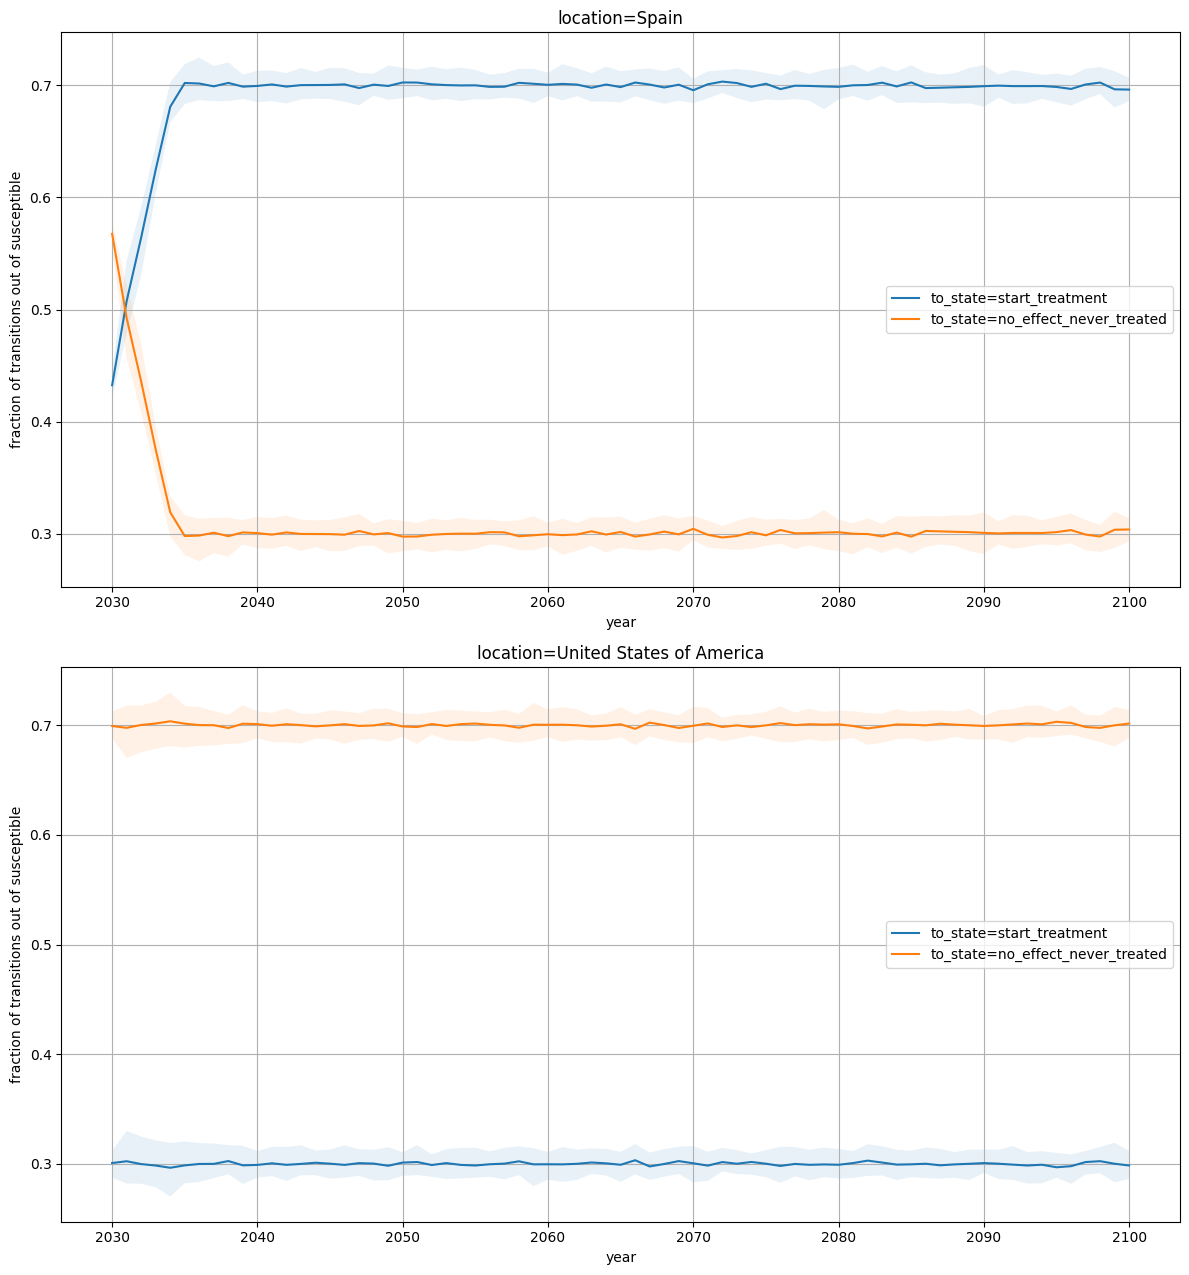

In [38]:
fig = plot_over_time_by_column_for_row_x_1(
    initiate_vs_not,
    'to_state',
    'location',
    ylabel='fraction of transitions out of susceptible',
)
for ax in fig.axes:
    # Looks like this is unnecessary after converting year to int
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)

# Check #2 (completes vs. discontinues treatment)

10% of transitions to Full treatment effect status are by simulants who
discontinue treatment

## Looks good

In [39]:
treatment_transitions.from_state.unique()

['start_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'susceptible_to_treatment']
Categories (6, object): ['full_effect_long', 'full_effect_short', 'start_treatment', 'susceptible_to_treatment', 'waning_effect_long', 'waning_effect_short']

In [40]:
# This gives the fraction of the total transitions out of
# 'start_treatment' that go to 'full_effect_long' vs.
# 'full_effect_short'. These ratios should be 0.9 and 0.1, respectively,
# across locations, age groups, draws, etc.
complete_vs_discontinue = ops.ratio(
    treatment_transitions,
    treatment_transitions,
    strata=[],
    prefilter_query="from_state == 'start_treatment'",
    numerator_broadcast=['to_state'],
    # denominator_broadcast=['to_state'],
)
complete_vs_discontinue

input_draw                    scenario                  location  \
0            2  bbbm_testing_and_treatment                     Spain   
1            2  bbbm_testing_and_treatment                     Spain   
2            2  bbbm_testing_and_treatment  United States of America   
3            2  bbbm_testing_and_treatment  United States of America   
4           13  bbbm_testing_and_treatment                     Spain   
..         ...                         ...                       ...   
95         480  bbbm_testing_and_treatment  United States of America   
96         499  bbbm_testing_and_treatment                     Spain   
97         499  bbbm_testing_and_treatment                     Spain   
98         499  bbbm_testing_and_treatment  United States of America   
99         499  bbbm_testing_and_treatment  United States of America   

             to_state     value numerator_measure denominator_measure  \
0    full_effect_long  0.900450  transition_count    transition_count   
1   full_effect_short  0.099550  transition_count    transition_count   
2    full_effect_long  0.900213  transition_count    transition_count   
3   full_effect_short  0.099787  transition_count    transition_count   
4    full_effect_long  0.901750  transition_count    transition_count   
..                ...       ...               ...                 ...   
95  full_effect_short  0.100876  transition_count    transition_count   
96   full_effect_long  0.900082  transition_count    transition_count   
97  full_effect_short  0.099918  transition_count    transition_count   
98   full_effect_long  0.900584  transition_count    transition_count   
99  full_effect_short  0.099416  transition_count    transition_count   

    multiplier  
0            1  
1            1  
2            1  
3            1  
4            1  
..         ...  
95           1  
96           1  
97           1  
98           1  
99           1  

[100 rows x 8 columns]

In [41]:
# Draw 2 in Japan: ratio of fraction of transitions to full_effect_long
# to fraction of transitions to full_effect short (rowss 0 and 1 above),
# gives the same value as the row for draw 2 in Japan in the table
# below:
# 8	2	bbbm_testing_and_treatment	Japan	8.956227	transition_count	transition_count	1
0.899560 / 0.100440

8.956192751891678

In [42]:
# This gives the ratio of the total transitions from start -> long to
# start -> short. The ratio should be approximately 9.0 for all
# locations, draws, age groups, etc. These ratios are equivalent to
# dividing the 'full_effect_long' rows in the previous dataframe by the
# 'full_effect_short' rows (see above cell for an example).
complete_to_discontinue_ratio = ops.ratio(
    treatment_transitions.query("to_state == 'full_effect_long'"),
    treatment_transitions.query("to_state == 'full_effect_short'"),
    strata=[],
    prefilter_query="from_state == 'start_treatment'",
    # numerator_broadcast=['to_state'],
    # denominator_broadcast=['to_state'],
)
complete_to_discontinue_ratio

input_draw                    scenario                  location     value  \
0         113  bbbm_testing_and_treatment                     Spain  9.112231   
1         113  bbbm_testing_and_treatment  United States of America  9.141705   
2         356  bbbm_testing_and_treatment                     Spain  8.984919   
3         356  bbbm_testing_and_treatment  United States of America  8.995781   
4         177  bbbm_testing_and_treatment                     Spain  9.105810   
5         177  bbbm_testing_and_treatment  United States of America  8.979842   
6           2  bbbm_testing_and_treatment                     Spain  9.045190   
7           2  bbbm_testing_and_treatment  United States of America  9.021351   
8          24  bbbm_testing_and_treatment                     Spain  9.047761   
9          24  bbbm_testing_and_treatment  United States of America  9.165144   
10        460  bbbm_testing_and_treatment                     Spain  9.216917   
11        460  bbbm_testing_and_treatment  United States of America  9.251363   
12        346  bbbm_testing_and_treatment                     Spain  9.008832   
13        346  bbbm_testing_and_treatment  United States of America  9.203879   
14         89  bbbm_testing_and_treatment                     Spain  8.999547   
15         89  bbbm_testing_and_treatment  United States of America  8.868866   
16        446  bbbm_testing_and_treatment                     Spain  9.009773   
17        446  bbbm_testing_and_treatment  United States of America  9.005360   
18        392  bbbm_testing_and_treatment                     Spain  8.902852   
19        392  bbbm_testing_and_treatment  United States of America  9.015944   
20         41  bbbm_testing_and_treatment                     Spain  8.989674   
21         41  bbbm_testing_and_treatment  United States of America  9.022677   
22        317  bbbm_testing_and_treatment                     Spain  8.945573   
23        317  bbbm_testing_and_treatment  United States of America  9.139453   
24        273  bbbm_testing_and_treatment                     Spain  8.953713   
25        273  bbbm_testing_and_treatment  United States of America  8.869302   
26        262  bbbm_testing_and_treatment                     Spain  8.969008   
27        262  bbbm_testing_and_treatment  United States of America  9.038509   
28        258  bbbm_testing_and_treatment                     Spain  8.815459   
29        258  bbbm_testing_and_treatment  United States of America  8.880938   
30         13  bbbm_testing_and_treatment                     Spain  9.178106   
31         13  bbbm_testing_and_treatment  United States of America  9.323021   
32        480  bbbm_testing_and_treatment                     Spain  8.892491   
33        480  bbbm_testing_and_treatment  United States of America  8.913153   
34        158  bbbm_testing_and_treatment                     Spain  9.100007   
35        158  bbbm_testing_and_treatment  United States of America  9.173984   
36        169  bbbm_testing_and_treatment                     Spain  9.202552   
37        169  bbbm_testing_and_treatment  United States of America  9.022714   
38        199  bbbm_testing_and_treatment                     Spain  9.067095   
39        199  bbbm_testing_and_treatment  United States of America  9.031706   
40        323  bbbm_testing_and_treatment                     Spain  8.890033   
41        323  bbbm_testing_and_treatment  United States of America  8.820185   
42        265  bbbm_testing_and_treatment                     Spain  8.985518   
43        265  bbbm_testing_and_treatment  United States of America  8.921426   
44         46  bbbm_testing_and_treatment                     Spain  9.064551   
45         46  bbbm_testing_and_treatment  United States of America  9.098595   
46        499  bbbm_testing_and_treatment                     Spain  9.008226   
47        499  bbbm_testing_and_treatment  United States of America  9.058722   
48        457  bbbm_testing_and_tr

In [43]:
summarize_sim_data(complete_to_discontinue_ratio)

count  \
denominator_measure location                 multiplier numerator_measure scenario                            
transition_count    Spain                    1          transition_count  bbbm_testing_and_treatment   25.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment   25.0   

                                                                                                          mean  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    Spain                    1          transition_count  bbbm_testing_and_treatment  9.020156   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  9.039843   

                                                                                                           std  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    Spain                    1          transition_count  bbbm_testing_and_treatment  0.097999   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  0.125811   

                                                                                                           min  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    Spain                    1          transition_count  bbbm_testing_and_treatment  8.815459   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  8.820185   

                                                                                                         lower  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    Spain                    1          transition_count  bbbm_testing_and_treatment  8.860204   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  8.849394   

                                                                                                           50%  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    Spain                    1          transition_count  bbbm_testing_and_treatment  9.008226   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  9.022714   

                                                                                                         upper  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    Spain                    1          transition_count  bbbm_testing_and_treatment  9.208298   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  9.280026   

                                                                                                           max  
denominator_measure location                 multiplier numerator_measure scenario                              
transition_count    Spain                    1          transition_count  bbbm_testing_and_treatment  9.216917  
                    United States of America 1          transition_count  bbbm_testing_and_treatment  9.323021

In [44]:
summarize_sim_data(complete_vs_discontinue)

count  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                   
transition_count    Spain                    1          transition_count  bbbm_testing_and_treatment full_effect_long    25.0   
                                                                                                     full_effect_short   25.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long    25.0   
                                                                                                     full_effect_short   25.0   

                                                                                                                            mean  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    Spain                    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.900192   
                                                                                                     full_effect_short  0.099808   
                    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.900382   
                                                                                                     full_effect_short  0.099618   

                                                                                                                             std  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    Spain                    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.000975   
                                                                                                     full_effect_short  0.000975   
                    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.001244   
                                                                                                     full_effect_short  0.001244   

                                                                                                                             min  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    Spain                    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.898120   
                                                                                                     full_effect_short  0.097877   
                    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.898169   
                                                                                                     full_effect_short  0.096871   

                                                                                                                           lower  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    Spain                    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.898581   
                                                                                                     full_effect_short  0.097960   
                    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.898470   
                                                                                                     full_effect_short  0.097277   

                                                                                                                             50%  \
denominator_measure location             

# Check #3 (durations of full vs. waning treatment)

Full/Waning durations are accurate (use person-time ratios between
states?)

## Strategy

Look at ratio of person-time in each state to the person-time in the
`'start_treatment'` state. Using the fact that 90% of simulants complete
treatment and end up in the "long" states, while 10% of simulants
discontinue treatment and end up in the "short" states, we can predict
what these ratios should be.

## Results

Things look good except for the `'waning_effect_long'` state, whose
ratio to the `'start_treatment'` state looks too low (it's the same as
for the `'full_effect_long'` state).

In [45]:
all_tx_states = person_time_treatment.sub_entity.unique()
all_tx_states

['susceptible_to_treatment', 'start_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'start_treatment', 'susceptible_to_treatment', 'waning_effect_long', 'waning_effect_short']

In [46]:
no_effect_states = [state for state in all_tx_states if 'no_effect' in state]
no_effect_states

['no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']

In [47]:
# Compute ratio of person-time in each state to the person-time in the
# "start_treatment" state
tx_person_time_ratios = ops.ratio(
    person_time_treatment,
    person_time_treatment.query("sub_entity == 'start_treatment'"),
    strata=['event_year'],
    prefilter_query=(
        "scenario == 'bbbm_testing_and_treatment'"
        f" and event_year >= 2030" #" and age_group in {treatment_eligible_age_groups}"
        f" and sub_entity not in {no_effect_states + ['susceptible_to_treatment']}"
    ),
    numerator_broadcast=['sub_entity'],
)
tx_person_time_ratios

event_year  input_draw                    scenario  \
0            2030           2  bbbm_testing_and_treatment   
1            2030           2  bbbm_testing_and_treatment   
2            2030           2  bbbm_testing_and_treatment   
3            2030           2  bbbm_testing_and_treatment   
4            2030           2  bbbm_testing_and_treatment   
...           ...         ...                         ...   
17745        2100         499  bbbm_testing_and_treatment   
17746        2100         499  bbbm_testing_and_treatment   
17747        2100         499  bbbm_testing_and_treatment   
17748        2100         499  bbbm_testing_and_treatment   
17749        2100         499  bbbm_testing_and_treatment   

                       location           sub_entity      value  \
0                         Spain      start_treatment   1.000000   
1                         Spain     full_effect_long   0.000000   
2                         Spain    full_effect_short   0.000000   
3                         Spain   waning_effect_long   0.000000   
4                         Spain  waning_effect_short   0.000000   
...                         ...                  ...        ...   
17745  United States of America      start_treatment   1.000000   
17746  United States of America     full_effect_long   8.486598   
17747  United States of America    full_effect_short   0.083505   
17748  United States of America   waning_effect_long  10.894845   
17749  United States of America  waning_effect_short   0.514433   

      numerator_measure denominator_measure  multiplier  
0           person_time         person_time           1  
1           person_time         person_time           1  
2           person_time         person_time           1  
3           person_time         person_time           1  
4           person_time         person_time           1  
...                 ...                 ...         ...  
17745       person_time         person_time           1  
17746       person_time         person_time           1  
17747       person_time         person_time           1  
17748       person_time         person_time           1  
17749       person_time         person_time           1  

[17750 rows x 9 columns]

In [48]:
tx_state_durations = pd.DataFrame(
    {
        # Durations from state diagram in treatment documentation
        'duration': [0.5, 5.0, 0.5, 9.0, 2.5],
        # 90% of people complete treatment and get long treatment
        # effect, 10% discontinue and get short treatment effect 
        'population_fraction': [1, 0.9, 0.1, 0.9, 0.1],
    },
    index=pd.CategoricalIndex(
        ['start_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short'],
        name='sub_entity',
    )
)
# Compute the ratio of the population-weighted duration of each state to
# the duration of the "start treatment" state.
tx_state_durations['target_person_time_ratio'] = (
    tx_state_durations['duration'] * tx_state_durations['population_fraction']
    / tx_state_durations.at['start_treatment', 'duration']
)
tx_state_durations


duration  population_fraction  target_person_time_ratio
sub_entity                                                                  
start_treatment           0.5                  1.0                       1.0
full_effect_long          5.0                  0.9                       9.0
full_effect_short         0.5                  0.1                       0.1
waning_effect_long        9.0                  0.9                      16.2
waning_effect_short       2.5                  0.1                       0.5

In [49]:
# For posting in Slack...
print(tx_state_durations.rename(
    columns={'population_fraction': 'pop_frac', 'target_person_time_ratio': 'pt_ratio'}))

                     duration  pop_frac  pt_ratio
sub_entity                                       
start_treatment           0.5       1.0       1.0
full_effect_long          5.0       0.9       9.0
full_effect_short         0.5       0.1       0.1
waning_effect_long        9.0       0.9      16.2
waning_effect_short       2.5       0.1       0.5


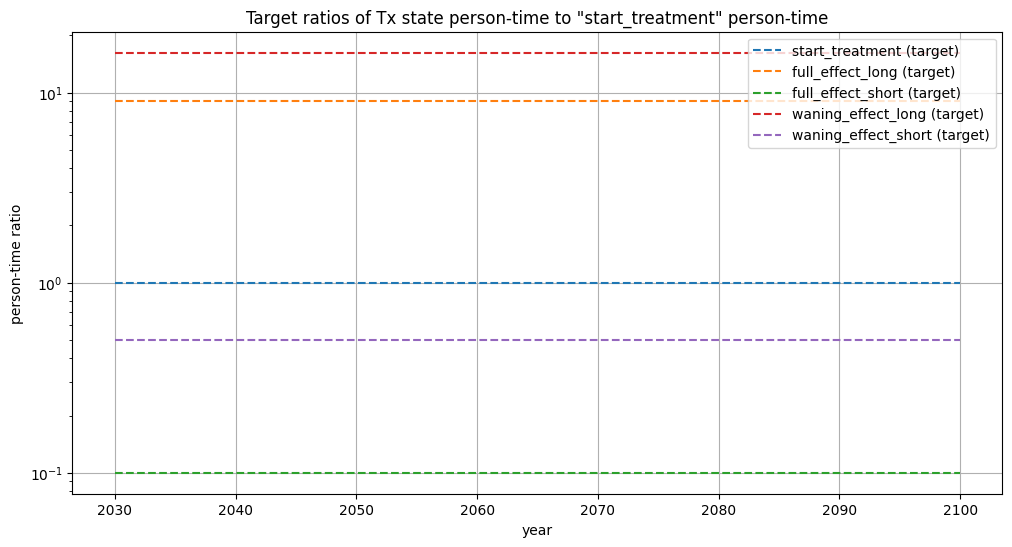

In [50]:
def plot_treatment_state_targets(tx_state_durations, column, ax):
    """Plot horizontal lines for values in one column of the treatment
    state durations table.
    """
    existing_lines = ax.get_lines()
    if len(existing_lines) == 0:
        # Axes.hlines plots all lines in a single color by default, so if you
        # want different colors, you have to explicitly cycle through them 
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

    for i, state in enumerate(tx_state_durations.index):
        # Find color corresponding to state if there already exists a
        # line for that state
        for line in existing_lines:
            if state in line.get_label():
                color = line.get_color()
                break
        # If there were no existing lines, go to next color in cycle
        if len(existing_lines) == 0:
            color = colors[i % len(colors)]
        ax.hlines(tx_state_durations.at[state, column], 2030, 2100, color, '--', label=f'{state} (target)')
    return ax

fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'target_person_time_ratio', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target ratios of Tx state person-time to "start_treatment" person-time',
)
ax.grid(True)
ax.legend()
ax.semilogy()
plt.show()

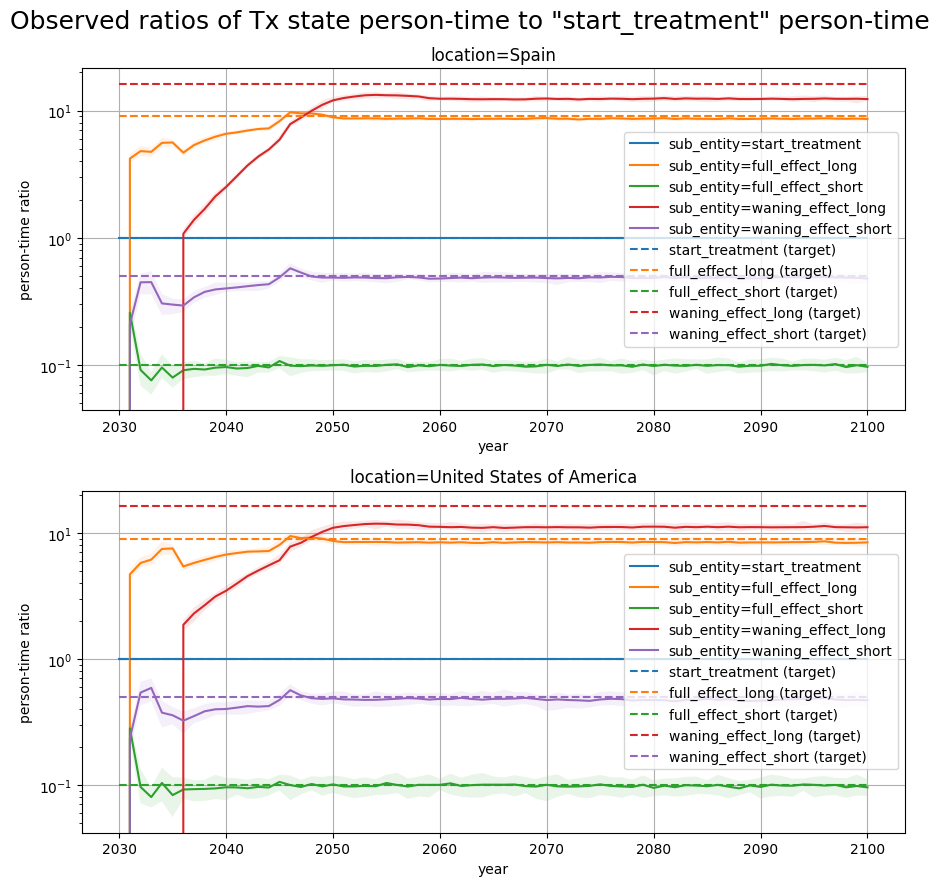

In [51]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_person_time_ratios,
    'sub_entity',
    'location',
    ylabel='person-time ratio',
    suptitle='Observed ratios of Tx state person-time to "start_treatment" person-time',
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'target_person_time_ratio', ax)
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
    ax.legend()
    ax.semilogy()
plt.show()

## Check values

In [52]:
tx_person_time_ratios.query("sub_entity == 'waning_effect_long' and event_year>2060").value.describe()

count    2000.000000
mean       11.716039
std         0.736597
min         9.864505
25%        11.067800
50%        11.795609
75%        12.361370
max        13.463710
Name: value, dtype: float64

In [53]:
tx_person_time_ratios.query("sub_entity == 'full_effect_long' and event_year>2060").value.describe()

count    2000.000000
mean        8.513422
std         0.269726
min         7.372439
25%         8.344919
50%         8.527281
75%         8.697716
max         9.520492
Name: value, dtype: float64

In [54]:
# Compute implied durations from the ratios above
# Target durations are (9, 5)
12.576105 / .9 * .5, 8.641488 / .9 * .5

(6.986725, 4.800826666666667)

## Look at actual person-time instead of the ratio

In [55]:
ops.describe(
    ops.stratify(
        person_time_treatment.query(
            "value > 0 and "
            "(sub_entity == 'start_treatment' or "
            " sub_entity.str.endswith('effect_long')) and event_year > 2060"
            " and location == 'Spain'"
        ),
        ['event_year', 'sub_entity']
    )
)

count  \
event_year location scenario                   sub_entity                  
2061       Spain    bbbm_testing_and_treatment full_effect_long     25.0   
                                               start_treatment      25.0   
                                               waning_effect_long   25.0   
2062       Spain    bbbm_testing_and_treatment full_effect_long     25.0   
                                               start_treatment      25.0   
...                                                                  ...   
2099       Spain    bbbm_testing_and_treatment start_treatment      25.0   
                                               waning_effect_long   25.0   
2100       Spain    bbbm_testing_and_treatment full_effect_long     25.0   
                                               start_treatment      25.0   
                                               waning_effect_long   25.0   

                                                                           mean  \
event_year location scenario                   sub_entity                         
2061       Spain    bbbm_testing_and_treatment full_effect_long     9721.296427   
                                               start_treatment      1129.481287   
                                               waning_effect_long  13995.099904   
2062       Spain    bbbm_testing_and_treatment full_effect_long     9729.249117   
                                               start_treatment      1130.557591   
...                                                                         ...   
2099       Spain    bbbm_testing_and_treatment start_treatment      1127.248953   
                                               waning_effect_long  13947.323970   
2100       Spain    bbbm_testing_and_treatment full_effect_long     9732.278713   
                                               start_treatment      1134.005749   
                                               waning_effect_long  13945.490267   

                                                                          std  \
event_year location scenario                   sub_entity                       
2061       Spain    bbbm_testing_and_treatment full_effect_long    378.718749   
                                               start_treatment      42.260045   
                                               waning_effect_long  495.806658   
2062       Spain    bbbm_testing_and_treatment full_effect_long    345.181533   
                                               start_treatment      45.654499   
...                                                                       ...   
2099       Spain    bbbm_testing_and_treatment start_treatment      46.081455   
                                               waning_effect_long  511.531583   
2100       Spain    bbbm_testing_and_treatment full_effect_long    395.813127   
                                               start_treatment      46.783458   
                                               waning_effect_long  509.068660   

                                                                            min  \
event_year location scenario                   sub_entity                         
2061       Spain    bbbm_testing_and_treatment full_effect_long     9030.488706   
                                               start_treatment      1028.966461   
                                               waning_effect_long  12839.906913   
2062       Spain    bbbm_testing_and_treatment full_effect_long     9108.720055   
                                               start_treatment      1049.396304   
...                                                                         ...   
2099       Spain    bbbm_testing_and_treatment start_treatment      1042.420260   
                                               waning_effect_long  12816.985626   
2100       Spain    bbbm_testing_and_treatment full_effect_long     8957.240246   
                               

In [56]:
9721.296427 / 1129.481287

8.606868071998433

In [57]:
13995.099904 / 1129.481287

12.390731980316554

# Check #4 (duration of start treatment/waiting for treatment)

“In treatment/waiting for treatment” duration is accurate (use
person-time ratios between states?)

This duration is supposed to be 6 months for all simulants.

## Strategy

To compute the average duration of each state, divide the total
person-time of that state by the number of simulants entering that
state, i.e., the the sum of transition counts where it's the `to_state`.

Alternatively, compute the average duration by dividing the total
person-time by the number of simulants *exiting* the state, i.e., the
sum of transition counts where it's the `from_state`.

## Results

I'm not sure how closely either of these strategies should match the
actual duration... Neither takes deaths into account, and I stratified
the calculations by year, which seems weird because some of the
durations are much longer than a year.

Nevertheless, the observed average durations for 4 out of 5 of the
states eventually converge to a value pretty close to the specified
duration, using either of the above two methods. The fifth state,
`'waning_effect_long'`, converges to different values in each of the
above two methods, neither of which is particularly close to the target
duration of 9 years. We think this is probably due to mortality.

In [58]:
person_time_treatment

age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
3077995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3077996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3077997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3077998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3077999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw      measure  \
0        treatment       cause        2025        113  person_time   
1        treatment       cause        2025        113  person_time   
2        treatment       cause        2025        113  person_time   
3        treatment       cause        2025        113  person_time   
4        treatment       cause        2025        113  person_time   
...            ...         ...         ...        ...          ...   
3077995  treatment       cause        2100        457  person_time   
3077996  treatment       cause        2100        457  person_time   
3077997  treatment       cause        2100        457  person_time   
3077998  treatment       cause        2100        457  person_time   
3077999  treatment       cause        2100        457  person_time   

                           scenario     sex                sub_entity  \
0                          baseline  Female  susceptible_to_treatment   
1                          baseline  Female           start_treatment   
2                          baseline  Female          full_effect_long   
3                          baseline  Female         full_effect_short   
4                          baseline  Female        waning_effect_long   
...                             ...     ...                       ...   
3077995  bbbm_testing_and_treatment    Male        waning_effect_long   
3077996  bbbm_testing_and_treatment    Male       waning_effect_short   
3077997  bbbm_testing_and_treatment    Male      no_effect_after_long   
3077998  bbbm_testing_and_treatment    Male     no_effect_after_short   
3077999  bbbm_testing_and_treatment    Male   no_effect_never_treated   

              value                  location  
0          0.498289                     Spain  
1          0.000000                     Spain  
2          0.000000                     Spain  
3          0.000000                     Spain  
4          0.000000                     Spain  
...             ...                       ...  
3077995    0.000000  United States of America  
3077996    0.000000  United States of America  
3077997   96.169747  United States of America  
3077998   10.962355  United States of America  
3077999  229.711157  United States of America  

[3078000 rows x 12 columns]

In [59]:
treatment_transitions.query("value>0")

age_group                                      artifact_path  \
427600  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
427601  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
427606  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
427607  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
427608  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
851164  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   
851172  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   
851180  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   
851188  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   
851196  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   

           entity entity_type event_year input_draw                  location  \
427600  treatment       cause       2030        113                     Spain   
427601  treatment       cause       2030        113                     Spain   
427606  treatment       cause       2030        113                     Spain   
427607  treatment       cause       2030        113                     Spain   
427608  treatment       cause       2030        113                     Spain   
...           ...         ...        ...        ...                       ...   
851164  treatment       cause       2100         46  United States of America   
851172  treatment       cause       2100        499  United States of America   
851180  treatment       cause       2100        499  United States of America   
851188  treatment       cause       2100        457  United States of America   
851196  treatment       cause       2100        457  United States of America   

                 measure                    scenario     sex  \
427600  transition_count  bbbm_testing_and_treatment  Female   
427601  transition_count  bbbm_testing_and_treatment  Female   
427606  transition_count  bbbm_testing_and_treatment  Female   
427607  transition_count  bbbm_testing_and_treatment  Female   
427608  transition_count  bbbm_testing_and_treatment    Male   
...                  ...                         ...     ...   
851164  transition_count  bbbm_testing_and_treatment    Male   
851172  transition_count  bbbm_testing_and_treatment  Female   
851180  transition_count  bbbm_testing_and_treatment    Male   
851188  transition_count  bbbm_testing_and_treatment  Female   
851196  transition_count  bbbm_testing_and_treatment    Male   

                                               sub_entity  value  \
427600                start_treatment_to_full_effect_long   49.0   
427601               start_treatment_to_full_effect_short    5.0   
427606        susceptible_to_treatment_to_start_treatment   73.0   
427607  susceptible_to_treatment_to_no_effect_never_tr...  115.0   
427608                start_treatment_to_full_effect_long   31.0   
...                                                   ...    ...   
851164         waning_effect_long_to_no_effect_after_long   37.0   
851172         waning_effect_long_to_no_effect_after_long   37.0   
851180         waning_effect_long_to_no_effect_after_long   17.0   
851188         waning_effect_long_to_no_effect_after_long   86.0   
851196         waning_effect_long_to_no_effect_after_long   28.0   

                      from_state                 to_state  
427600           start_treatment         full_effect_long  
427601           start_treatment        full_effect_short  
427606  susceptible_to_treatment          start_treatment  
427607  susceptible_to_treatment  no_effect_never_treated  
427608           start_treatment         full_effect_long  
...                          ...                      ...  
851164        waning_effect_long     no_effect_after_long  
851172        waning_effect_long     no_effect_after_long  
851180        waning_effect_long     no_effect_after_lo

In [60]:
tx_state_mean_durations_incoming = ops.ratio(
    person_time_treatment.assign(to_state=lambda df: df['sub_entity']),
    treatment_transitions.query("value>0"),
    strata=['event_year', 'to_state'],
    prefilter_query=(
        "scenario=='bbbm_testing_and_treatment' and event_year >= 2030"
    )
)
tx_state_mean_durations_incoming

event_year             to_state  input_draw  \
0            2030     full_effect_long           2   
1            2030     full_effect_long           2   
2            2030     full_effect_long          13   
3            2030     full_effect_long          13   
4            2030     full_effect_long          24   
...           ...                  ...         ...   
31945        2100  waning_effect_short         460   
31946        2100  waning_effect_short         480   
31947        2100  waning_effect_short         480   
31948        2100  waning_effect_short         499   
31949        2100  waning_effect_short         499   

                         scenario                  location     value  \
0      bbbm_testing_and_treatment                     Spain  0.000000   
1      bbbm_testing_and_treatment  United States of America  0.000000   
2      bbbm_testing_and_treatment                     Spain  0.000000   
3      bbbm_testing_and_treatment  United States of America  0.000000   
4      bbbm_testing_and_treatment                     Spain  0.000000   
...                           ...                       ...       ...   
31945  bbbm_testing_and_treatment  United States of America  2.385747   
31946  bbbm_testing_and_treatment                     Spain  2.379217   
31947  bbbm_testing_and_treatment  United States of America  2.341422   
31948  bbbm_testing_and_treatment                     Spain  2.626053   
31949  bbbm_testing_and_treatment  United States of America  3.108077   

      numerator_measure denominator_measure  multiplier  
0           person_time    transition_count           1  
1           person_time    transition_count           1  
2           person_time    transition_count           1  
3           person_time    transition_count           1  
4           person_time    transition_count           1  
...                 ...                 ...         ...  
31945       person_time    transition_count           1  
31946       person_time    transition_count           1  
31947       person_time    transition_count           1  
31948       person_time    transition_count           1  
31949       person_time    transition_count           1  

[31950 rows x 9 columns]

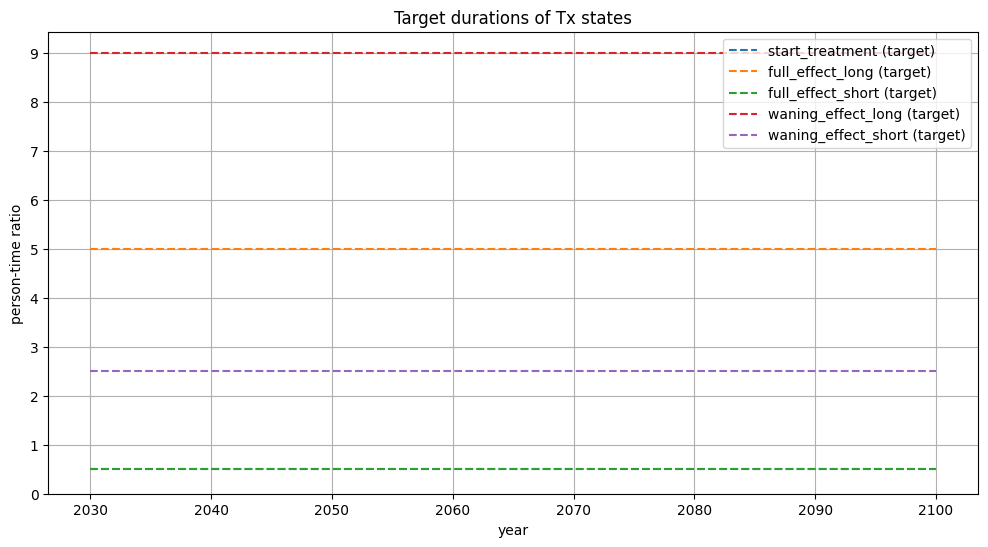

In [61]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target durations of Tx states',
)
ax.grid(True)
ax.legend()
ax.set(yticks=range(0,10))
# ax.semilogy()
plt.show()

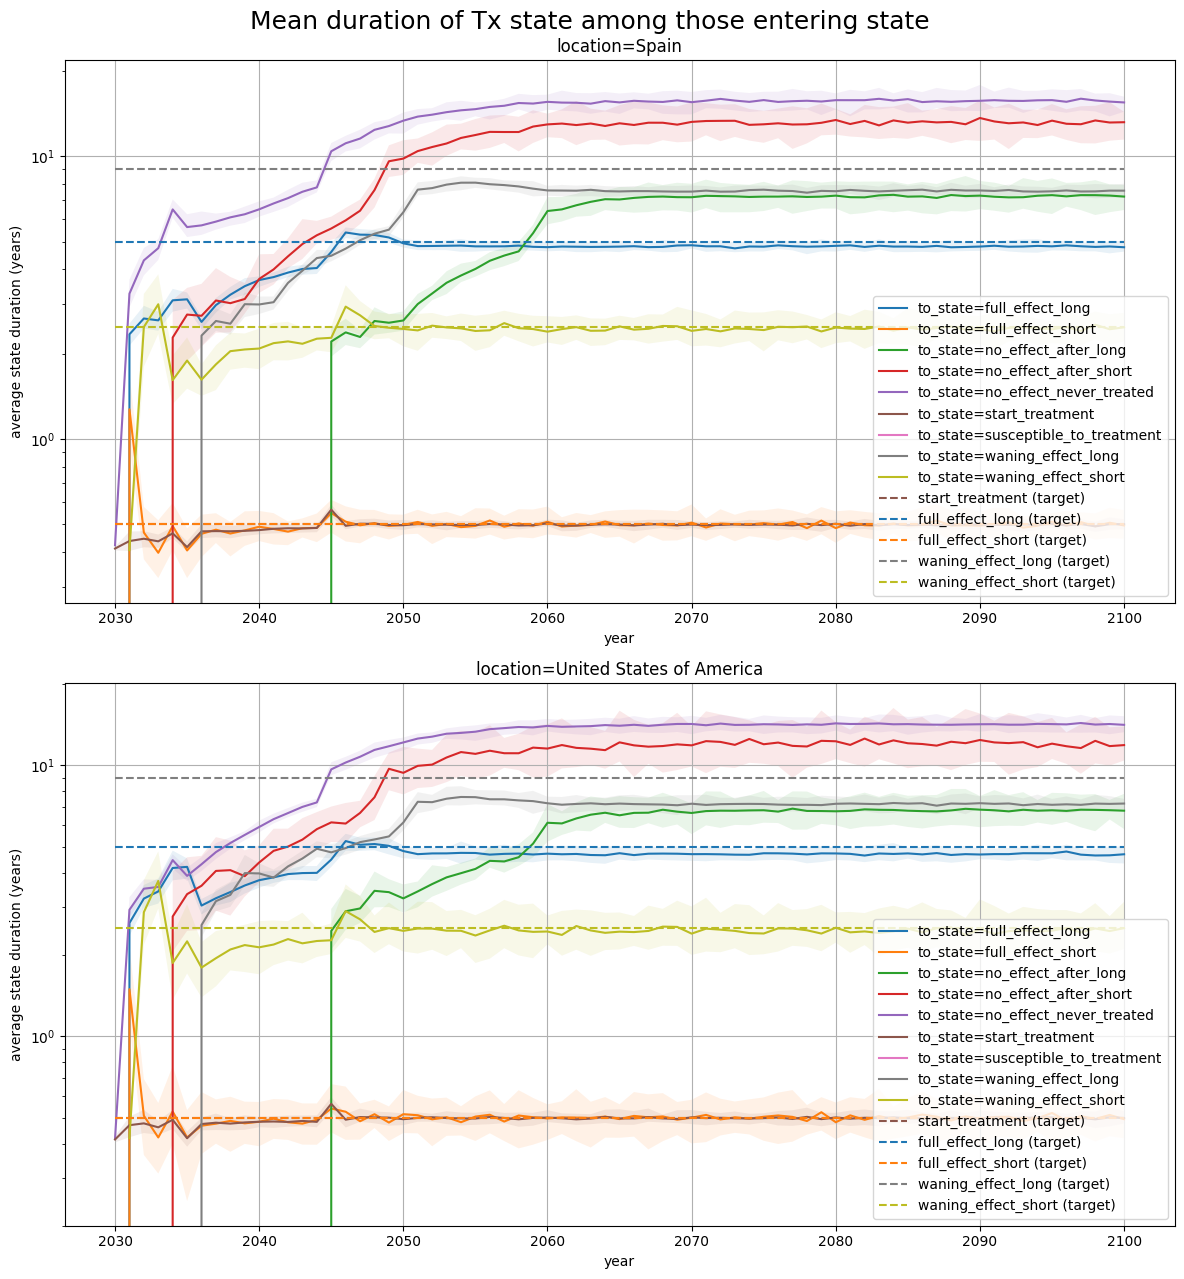

In [62]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_state_mean_durations_incoming,
    'to_state',
    'location',
    ylabel='average state duration (years)',
    suptitle="Mean duration of Tx state among those entering state",
    # axes_width=9,
    # axes_height=4,
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
    ax.legend()
    ax.grid(True)
    ax.semilogy()
plt.show()

In [63]:
tx_state_mean_durations_outgoing = ops.ratio(
    person_time_treatment.assign(from_state=lambda df: df['sub_entity']),
    treatment_transitions.query("value>0"),
    strata=['event_year', 'from_state'],
    prefilter_query=(
        "scenario=='bbbm_testing_and_treatment' and event_year >= 2030"
    )
)
tx_state_mean_durations_outgoing

event_year           from_state  input_draw  \
0            2030     full_effect_long           2   
1            2030     full_effect_long           2   
2            2030     full_effect_long          13   
3            2030     full_effect_long          13   
4            2030     full_effect_long          24   
...           ...                  ...         ...   
31945        2100  waning_effect_short         460   
31946        2100  waning_effect_short         480   
31947        2100  waning_effect_short         480   
31948        2100  waning_effect_short         499   
31949        2100  waning_effect_short         499   

                         scenario                  location     value  \
0      bbbm_testing_and_treatment                     Spain       NaN   
1      bbbm_testing_and_treatment  United States of America       NaN   
2      bbbm_testing_and_treatment                     Spain       NaN   
3      bbbm_testing_and_treatment  United States of America       NaN   
4      bbbm_testing_and_treatment                     Spain       NaN   
...                           ...                       ...       ...   
31945  bbbm_testing_and_treatment  United States of America  2.595483   
31946  bbbm_testing_and_treatment                     Spain  2.368548   
31947  bbbm_testing_and_treatment  United States of America  2.419469   
31948  bbbm_testing_and_treatment                     Spain  2.676798   
31949  bbbm_testing_and_treatment  United States of America  2.617328   

      numerator_measure denominator_measure  multiplier  
0           person_time    transition_count           1  
1           person_time    transition_count           1  
2           person_time    transition_count           1  
3           person_time    transition_count           1  
4           person_time    transition_count           1  
...                 ...                 ...         ...  
31945       person_time    transition_count           1  
31946       person_time    transition_count           1  
31947       person_time    transition_count           1  
31948       person_time    transition_count           1  
31949       person_time    transition_count           1  

[31950 rows x 9 columns]

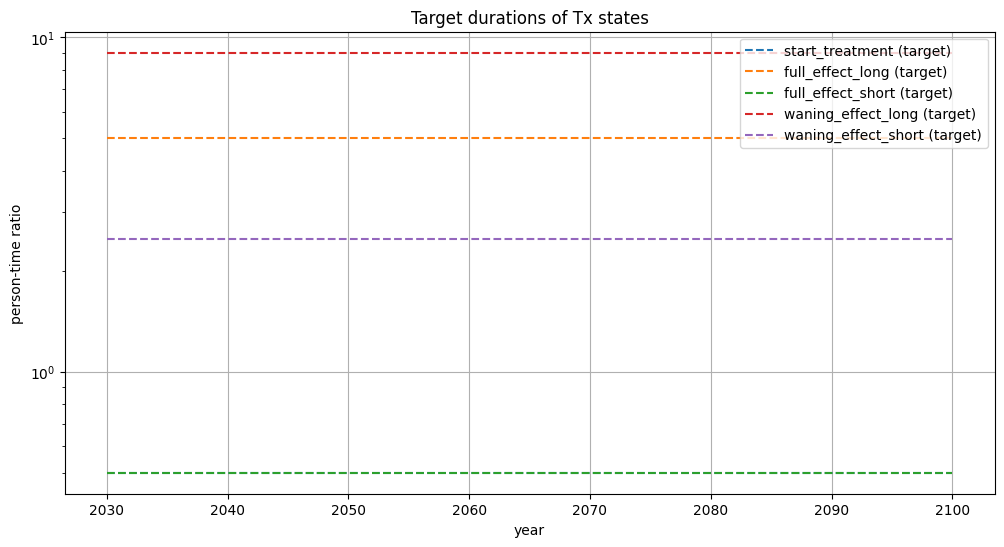

In [64]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target durations of Tx states',
)
ax.grid(True)
ax.legend()
ax.set(yticks=range(0,10))
ax.semilogy()
plt.show()

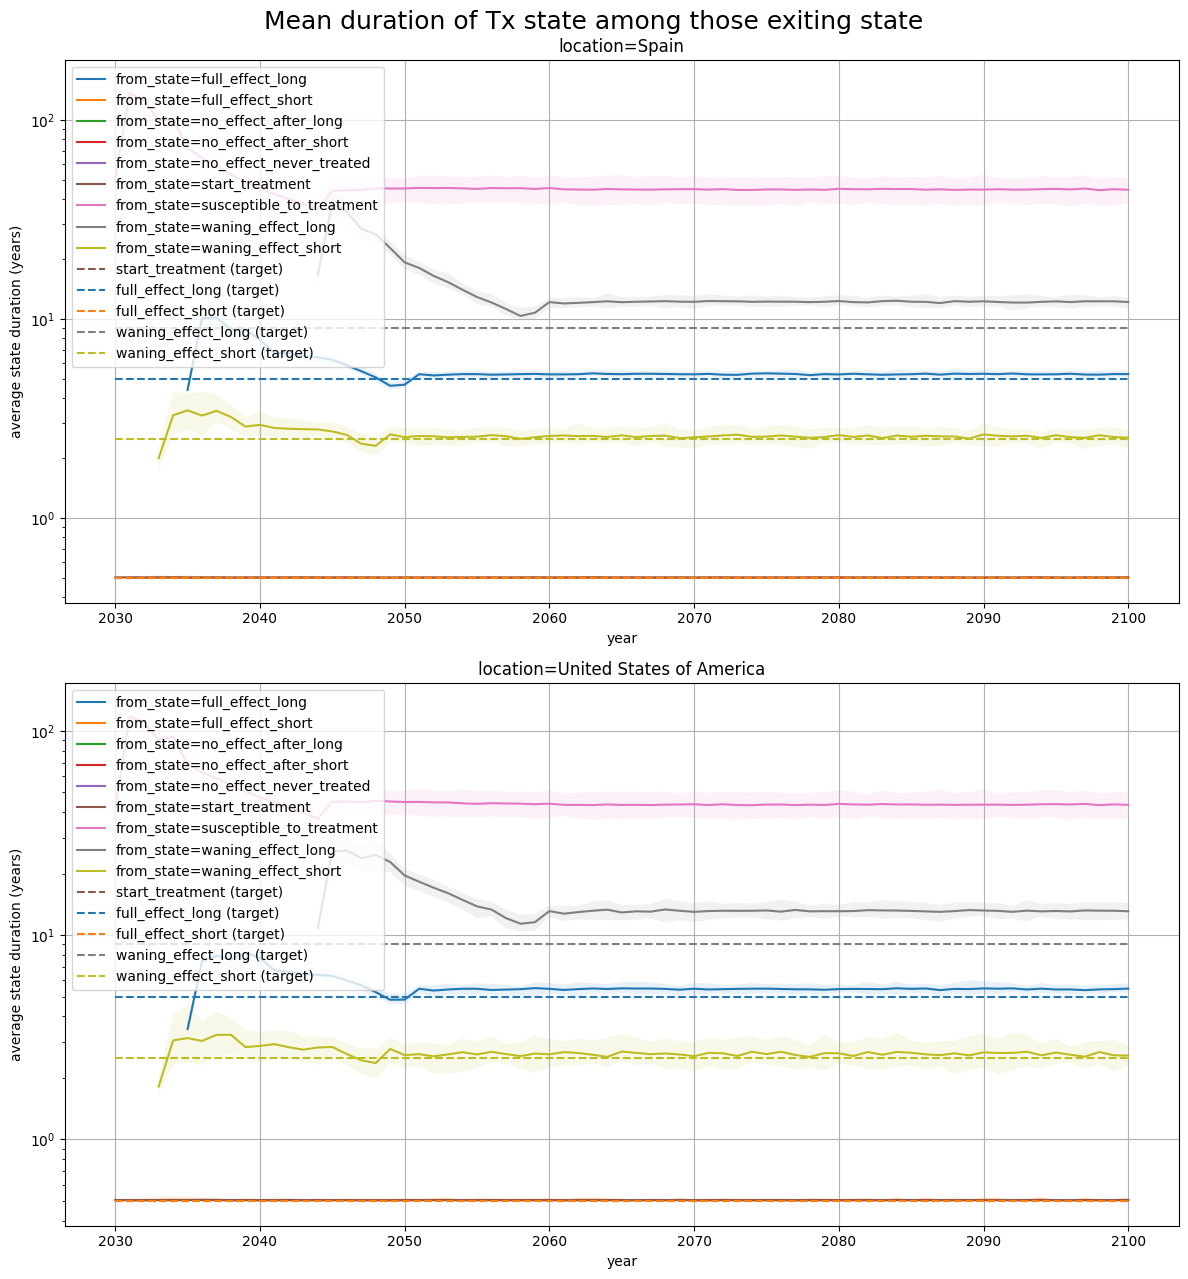

In [65]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_state_mean_durations_outgoing,
    'from_state',
    'location',
    ylabel='average state duration (years)',
    suptitle="Mean duration of Tx state among those exiting state",
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
    ax.legend()
    ax.grid(True)
    ax.semilogy()
plt.show()

## Check value of `waning_effect_long`

It's not close to 9 years in either graph.

In [66]:
tx_state_mean_durations_incoming.query("to_state == 'waning_effect_long' and event_year > 2060").value.describe()

count    2000.000000
mean        7.369718
std         0.301544
min         6.356391
25%         7.162249
50%         7.399613
75%         7.595294
max         8.256873
Name: value, dtype: float64

In [67]:
tx_state_mean_durations_outgoing.query("from_state == 'waning_effect_long' and event_year > 2060").value.describe()

count    2000.000000
mean       12.657778
std         0.754272
min        10.885510
25%        12.102432
50%        12.538150
75%        13.128980
max        15.574754
Name: value, dtype: float64

## By contrast, check the value of `full_effect_long`

It **is** close to 5 years in _both_ graphs.

In [68]:
tx_state_mean_durations_incoming.query("to_state == 'full_effect_long' and event_year > 2060").value.describe()

count    2000.000000
mean        4.753430
std         0.150228
min         4.153106
25%         4.659636
50%         4.760706
75%         4.855749
max         5.243601
Name: value, dtype: float64

In [69]:
tx_state_mean_durations_outgoing.query("from_state == 'full_effect_long' and event_year > 2060").value.describe()

count    2000.000000
mean        5.361468
std         0.175275
min         4.885144
25%         5.235377
50%         5.341939
75%         5.467000
max         6.090709
Name: value, dtype: float64

# Check #5 (Interactive sim)

I'm planning to do the interactive sim in another notebook.

# Check #6 (hazard ratio)

Check hazard ratios for simulants who begin treatment and those who
transition to *No treatment effect* (Check hazard ratio of treated to
not treated for hazard rate from BBBM to MCI)

## I think I can't check this in the outputs because neither cause transitions nor cause state person-time is stratified by treatment status

In [70]:
person_time_cause_states = load_sim_output(
    'person_time_alzheimers_disease_and_other_dementias'
)
print_memory_usage(person_time_cause_states)
person_time_cause_states

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/spain.hdf'])


193.920292 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
9233995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
9233996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
9233997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
9233998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
9233999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
0        alzheimers_disease_and_other_dementias       cause        2025   
1        alzheimers_disease_and_other_dementias       cause        2025   
2        alzheimers_disease_and_other_dementias       cause        2025   
3        alzheimers_disease_and_other_dementias       cause        2025   
4        alzheimers_disease_and_other_dementias       cause        2025   
...                                         ...         ...         ...   
9233995  alzheimers_disease_and_other_dementias       cause        2100   
9233996  alzheimers_disease_and_other_dementias       cause        2100   
9233997  alzheimers_disease_and_other_dementias       cause        2100   
9233998  alzheimers_disease_and_other_dementias       cause        2100   
9233999  alzheimers_disease_and_other_dementias       cause        2100   

        input_draw      measure                    scenario     sex  \
0              113  person_time                    baseline  Female   
1              113  person_time                    baseline  Female   
2              113  person_time                    baseline  Female   
3              113  person_time                    baseline  Female   
4              113  person_time                    baseline  Female   
...            ...          ...                         ...     ...   
9233995        457  person_time  bbbm_testing_and_treatment    Male   
9233996        457  person_time  bbbm_testing_and_treatment    Male   
9233997        457  person_time  bbbm_testing_and_treatment    Male   
9233998        457  person_time  bbbm_testing_and_treatment    Male   
9233999        457  person_time  bbbm_testing_and_treatment    Male   

                                     sub_entity                 treatment  \
0        alzheimers_blood_based_biomarker_state  susceptible_to_treatment   
1        alzheimers_blood_based_biomarker_state           start_treatment   
2        alzheimers_blood_based_biomarker_state          full_effect_long   
3        alzheimers_blood_based_biomarker_state         full_effect_short   
4        alzheimers_blood_based_biomarker_state        waning_effect_long   
...                                         ...                       ...   
9233995                alzheimers_disease_state        waning_effect_long   
9233996                alzheimers_disease_state       waning_effect_short   
9233997                alzheimers_disease_state      no_effect_after_long   
9233998                alzheimers_disease_state     no_effect_after_short   
9233999                alzheimers_disease_state   no_effect_never_treated   

              value                  location  
0          0.000000                     Spain  
1          0.000000                     Spain  
2          0.000000                     Spain  
3          0.000000                     Spain  
4          0.000000                     Spain  
...             ...                       ...  
9233995    0.000000  United States of America  
9233996    0.000000  United States of America  
9233997   51.822040  United Stat

In [71]:
person_time_cause_states.dtypes

age_group        category
artifact_path    category
entity           category
entity_type      category
event_year          int16
input_draw       category
measure          category
scenario         category
sex              category
sub_entity       category
treatment        category
value             float64
location         category
dtype: object

In [72]:
person_time_cause_states.treatment.unique()

['susceptible_to_treatment', 'start_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'start_treatment', 'susceptible_to_treatment', 'waning_effect_long', 'waning_effect_short']

In [73]:
person_time_cause_states.sub_entity.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state', 'alzheimers_disease_state']
Categories (3, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']

In [74]:
transition_count_cause_states = (
    load_sim_output(
        'transition_count_alzheimers_disease_and_other_dementias'
    )
    # Display memory usage of loaded dataframe before adding columns
    .pipe(lambda df: print_memory_usage(df) or df)
    # Add columns for from and to state
    .pipe(lambda df: df.join(
        cleaning.extract_transition_states(df, 'sub_entity'))
    )
    # Display memory usage of loaded dataframe after adding columns
    .pipe(lambda df: print_memory_usage(df) or df)
    # Convert the new columns to Categoricals
    .pipe(convert_to_categorical)
)
print_memory_usage(transition_count_cause_states)
transition_count_cause_states

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/spain.hdf'])
129.28229 MB
1280.45429 MB
135.441592 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
6155995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
6155996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
6155997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
6155998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
6155999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type event_year  \
0        alzheimers_disease_and_other_dementias       cause       2025   
1        alzheimers_disease_and_other_dementias       cause       2025   
2        alzheimers_disease_and_other_dementias       cause       2025   
3        alzheimers_disease_and_other_dementias       cause       2025   
4        alzheimers_disease_and_other_dementias       cause       2025   
...                                         ...         ...        ...   
6155995  alzheimers_disease_and_other_dementias       cause       2100   
6155996  alzheimers_disease_and_other_dementias       cause       2100   
6155997  alzheimers_disease_and_other_dementias       cause       2100   
6155998  alzheimers_disease_and_other_dementias       cause       2100   
6155999  alzheimers_disease_and_other_dementias       cause       2100   

        input_draw           measure                    scenario     sex  \
0              113  transition_count                    baseline  Female   
1              113  transition_count                    baseline  Female   
2              113  transition_count                    baseline  Female   
3              113  transition_count                    baseline  Female   
4              113  transition_count                    baseline  Female   
...            ...               ...                         ...     ...   
6155995        457  transition_count  bbbm_testing_and_treatment    Male   
6155996        457  transition_count  bbbm_testing_and_treatment    Male   
6155997        457  transition_count  bbbm_testing_and_treatment    Male   
6155998        457  transition_count  bbbm_testing_and_treatment    Male   
6155999        457  transition_count  bbbm_testing_and_treatment    Male   

                                                sub_entity  \
0        alzheimers_blood_based_biomarker_state_to_alzh...   
1        alzheimers_blood_based_biomarker_state_to_alzh...   
2        alzheimers_blood_based_biomarker_state_to_alzh...   
3        alzheimers_blood_based_biomarker_state_to_alzh...   
4        alzheimers_blood_based_biomarker_state_to_alzh...   
...                                                    ...   
6155995  alzheimers_mild_cognitive_impairment_state_to_...   
6155996  alzheimers_mild_cognitive_impairment_state_to_...   
6155997  alzheimers_mild_cognitive_impairment_state_to_...   
6155998  alzheimers_mild_cognitive_impairment_state_to_...   
6155999  alzheimers_mild_cognitive_impairment_state_to_...   

                        treatment  value                  location  \
0        susceptible_to_treatment    0.0                     Spain   
1                 start_treatment    0.0                     Spain   
2                full_effect_long    0.0                     Spain   
3               full_effect_short    0.0                     Spain   
4              waning_effect_long    0.0                     Spain   
...                           ...    ...                       ...   
6155995        waning_effect_long    0.0  United States of America   
6155996       waning_effect_short   

In [75]:
transition_count_cause_states.from_state.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state']
Categories (2, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state']

In [76]:
incidence_rates_by_treatment = ops.ratio(
    transition_count_cause_states,
    person_time_cause_states.rename(columns={'sub_entity': 'from_state'}),
    strata=['event_year', 'from_state', 'treatment'],
    numerator_broadcast='to_state', # Shouldn't actually broadcast, just record it
    dropna=True,
)
incidence_rates_by_treatment

event_year                                  from_state  \
0            2025      alzheimers_blood_based_biomarker_state   
1            2025      alzheimers_blood_based_biomarker_state   
2            2025      alzheimers_blood_based_biomarker_state   
3            2025      alzheimers_blood_based_biomarker_state   
4            2025      alzheimers_blood_based_biomarker_state   
...           ...                                         ...   
84092        2100  alzheimers_mild_cognitive_impairment_state   
84093        2100  alzheimers_mild_cognitive_impairment_state   
84094        2100  alzheimers_mild_cognitive_impairment_state   
84095        2100  alzheimers_mild_cognitive_impairment_state   
84096        2100  alzheimers_mild_cognitive_impairment_state   

                      treatment  input_draw                    scenario  \
0      susceptible_to_treatment           2                    baseline   
1      susceptible_to_treatment           2                    baseline   
2      susceptible_to_treatment           2                bbbm_testing   
3      susceptible_to_treatment           2                bbbm_testing   
4      susceptible_to_treatment           2  bbbm_testing_and_treatment   
...                         ...         ...                         ...   
84092       waning_effect_short         460  bbbm_testing_and_treatment   
84093       waning_effect_short         480  bbbm_testing_and_treatment   
84094       waning_effect_short         480  bbbm_testing_and_treatment   
84095       waning_effect_short         499  bbbm_testing_and_treatment   
84096       waning_effect_short         499  bbbm_testing_and_treatment   

                       location                                    to_state  \
0                         Spain  alzheimers_mild_cognitive_impairment_state   
1      United States of America  alzheimers_mild_cognitive_impairment_state   
2                         Spain  alzheimers_mild_cognitive_impairment_state   
3      United States of America  alzheimers_mild_cognitive_impairment_state   
4                         Spain  alzheimers_mild_cognitive_impairment_state   
...                         ...                                         ...   
84092  United States of America                    alzheimers_disease_state   
84093                     Spain                    alzheimers_disease_state   
84094  United States of America                    alzheimers_disease_state   
84095                     Spain                    alzheimers_disease_state   
84096  United States of America                    alzheimers_disease_state   

          value numerator_measure denominator_measure  multiplier  
0      0.071544  transition_count         person_time           1  
1      0.071522  transition_count         person_time           1  
2      0.071544  transition_count         person_time           1  
3      0.071522  transition_count         person_time           1  
4      0.071544  transition_count         person_time           1  
...         ...               ...                 ...         ...  
84092  0.243257  transition_count         person_time           1  
84093  0.273664  transition_count         person_time           1  
84094  0.273664  transition_count         person_time           1  
84095  0.206314  transition_count         person_time           1  
84096  0.302923  transition_count         person_time           1  

[84097 rows x 11 columns]

## Investigate infinite transition rates between disease states

My plotting code below initially failed with `FloatingPointError:
invalid value encountered in subtract` in the `lower` function, due to
infinities in the transition rates data.

According to the engineers, we may be getting 0 person-time in some
strata where counts are nonzero because person-time is recorded at the
beginning of a time step, while transition counts are recorded at the
end. So for example, if someone starts in preclinical, in the "waiting
for treatment" state, then transitions to MCI and to "full effect long"
on the same time step, then they would have their person-time recorded
in the (preclinical, waiting for treatment) stratum, but their disease
transition recorded in the (preclinical- > MCI, full effect long)
stratum.

The engineers said there was a bugfix in model 7.2 that *might* address
this problem, so I'll try this again there...

In [77]:
incidence_rates_by_treatment.value.describe()

count    8.409700e+04
mean              inf
std               NaN
min      0.000000e+00
25%      7.261321e-02
50%      9.421280e-02
75%      2.514709e-01
max               inf
Name: value, dtype: float64

In [127]:
inf = np.isinf(incidence_rates_by_treatment.value)
print(len(inf), "rows with infinite values")
incidence_rates_by_treatment.loc[inf].query(
    "from_state=='alzheimers_blood_based_biomarker_state'"
    # " and ~treatment.str.contains('no_effect')"
)

84097 rows with infinite values


event_year                              from_state  \
1500         2030  alzheimers_blood_based_biomarker_state   
1501         2030  alzheimers_blood_based_biomarker_state   
1502         2030  alzheimers_blood_based_biomarker_state   
1503         2030  alzheimers_blood_based_biomarker_state   
1504         2030  alzheimers_blood_based_biomarker_state   
...           ...                                     ...   
15847        2044  alzheimers_blood_based_biomarker_state   
15848        2044  alzheimers_blood_based_biomarker_state   
15849        2044  alzheimers_blood_based_biomarker_state   
15850        2044  alzheimers_blood_based_biomarker_state   
15851        2044  alzheimers_blood_based_biomarker_state   

                  treatment  input_draw                    scenario  \
1500       full_effect_long           2  bbbm_testing_and_treatment   
1501       full_effect_long           2  bbbm_testing_and_treatment   
1502       full_effect_long          13  bbbm_testing_and_treatment   
1503       full_effect_long          13  bbbm_testing_and_treatment   
1504       full_effect_long          24  bbbm_testing_and_treatment   
...                     ...         ...                         ...   
15847  no_effect_after_long         460  bbbm_testing_and_treatment   
15848  no_effect_after_long         480  bbbm_testing_and_treatment   
15849  no_effect_after_long         480  bbbm_testing_and_treatment   
15850  no_effect_after_long         499  bbbm_testing_and_treatment   
15851  no_effect_after_long         499  bbbm_testing_and_treatment   

                       location                                    to_state  \
1500                      Spain  alzheimers_mild_cognitive_impairment_state   
1501   United States of America  alzheimers_mild_cognitive_impairment_state   
1502                      Spain  alzheimers_mild_cognitive_impairment_state   
1503   United States of America  alzheimers_mild_cognitive_impairment_state   
1504                      Spain  alzheimers_mild_cognitive_impairment_state   
...                         ...                                         ...   
15847  United States of America  alzheimers_mild_cognitive_impairment_state   
15848                     Spain  alzheimers_mild_cognitive_impairment_state   
15849  United States of America  alzheimers_mild_cognitive_impairment_state   
15850                     Spain  alzheimers_mild_cognitive_impairment_state   
15851  United States of America  alzheimers_mild_cognitive_impairment_state   

       value numerator_measure denominator_measure  multiplier  
1500     inf  transition_count         person_time           1  
1501     inf  transition_count         person_time           1  
1502     inf  transition_count         person_time           1  
1503     inf  transition_count         person_time           1  
1504     inf  transition_count         person_time           1  
...      ...               ...                 ...         ...  
15847    inf  transition_count         person_time           1  
15848    inf  transition_count         person_time           1  
15849    inf  transition_count         person_time           1  
15850    inf  transition_count         person_time           1  
15851    inf  transition_count         person_time           1  

[245 rows x 11 columns]

In [126]:
transition_count_cause_states.query(
    "scenario=='bbbm_testing_and_treatment'"
    " and event_year==2044 and from_state=='alzheimers_blood_based_biomarker_state'"
    " and input_draw==499 and treatment=='no_effect_after_long'"
    " and age_group in @treatment_eligible_age_groups"
)

age_group                                      artifact_path  \
2926662  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
2926680  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
3131862  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
3131880  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
3337062  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
3337080  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
3542262  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
3542280  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
3747462  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
3747480  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
3952662  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
3952680  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
4157862  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
4157880  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
4363062  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
4363080  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
4568262  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
4568280  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
4773462  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
4773480  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type event_year  \
2926662  alzheimers_disease_and_other_dementias       cause       2044   
2926680  alzheimers_disease_and_other_dementias       cause       2044   
3131862  alzheimers_disease_and_other_dementias       cause       2044   
3131880  alzheimers_disease_and_other_dementias       cause       2044   
3337062  alzheimers_disease_and_other_dementias       cause       2044   
3337080  alzheimers_disease_and_other_dementias       cause       2044   
3542262  alzheimers_disease_and_other_dementias       cause       2044   
3542280  alzheimers_disease_and_other_dementias       cause       2044   
3747462  alzheimers_disease_and_other_dementias       cause       2044   
3747480  alzheimers_disease_and_other_dementias       cause       2044   
3952662  alzheimers_disease_and_other_dementias       cause       2044   
3952680  alzheimers_disease_and_other_dementias       cause       2044   
4157862  alzheimers_disease_and_other_dementias       cause       2044   
4157880  alzheimers_disease_and_other_dementias       cause       2044   
4363062  alzheimers_disease_and_other_dementias       cause       2044   
4363080  alzheimers_disease_and_other_dementias       cause       2044   
4568262  alzheimers_disease_and_other_dementias       cause       2044   
4568280  alzheimers_disease_and_other_dementias       cause       2044   
4773462  alzheimers_disease_and_other_dementias       cause       2044   
4773480  alzheimers_disease_and_other_dementias       cause       2044   

        input_draw           measure                    scenario     sex  \
2926662        499  transition_count  bbbm_testing_and_treatment  Female   
2926680        499  transition_count  bbbm_testing_and_treatment    Male   
3131862        499  transition_count  bbbm_testing_and_treatment  Female   
3131880        499  transition_count  bbbm_testing_and_treatment    Male   
3337062        499  transition_count  bbbm_testing_and_treatment  Female   
3337080        499  transition_count  bbbm_testing_and_treatment    Male   
3542262        499  transition_count  bbbm_testing_and_treatment  Female   
3542280        499  transition_count  bbbm_testing_and_treatment    Male   
3747462        499  transition_count  bbbm_testing_and_treatment  Female   
3747480        499  transition_count  bbbm_testing_and_treatment    Male   
3952662        499  transition_count  bbbm_testing_and_treatment  Female   
3952680        499  transiti

In [121]:
person_time_cause_states.query(
   "scenario=='bbbm_testing_and_treatment'"
    " and event_year==2044 and sub_entity=='alzheimers_blood_based_biomarker_state'"
    " and input_draw==499 and treatment=='full_effect_long'"
    " and age_group in @treatment_eligible_age_groups"
)

age_group                                      artifact_path  \
4389986  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
4390013  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
4697786  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
4697813  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
5005586  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
5005613  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
5313386  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
5313413  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
5621186  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
5621213  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
5928986  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
5929013  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
6236786  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
6236813  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
6544586  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
6544613  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
6852386  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
6852413  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
7160186  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
7160213  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
4389986  alzheimers_disease_and_other_dementias       cause        2044   
4390013  alzheimers_disease_and_other_dementias       cause        2044   
4697786  alzheimers_disease_and_other_dementias       cause        2044   
4697813  alzheimers_disease_and_other_dementias       cause        2044   
5005586  alzheimers_disease_and_other_dementias       cause        2044   
5005613  alzheimers_disease_and_other_dementias       cause        2044   
5313386  alzheimers_disease_and_other_dementias       cause        2044   
5313413  alzheimers_disease_and_other_dementias       cause        2044   
5621186  alzheimers_disease_and_other_dementias       cause        2044   
5621213  alzheimers_disease_and_other_dementias       cause        2044   
5928986  alzheimers_disease_and_other_dementias       cause        2044   
5929013  alzheimers_disease_and_other_dementias       cause        2044   
6236786  alzheimers_disease_and_other_dementias       cause        2044   
6236813  alzheimers_disease_and_other_dementias       cause        2044   
6544586  alzheimers_disease_and_other_dementias       cause        2044   
6544613  alzheimers_disease_and_other_dementias       cause        2044   
6852386  alzheimers_disease_and_other_dementias       cause        2044   
6852413  alzheimers_disease_and_other_dementias       cause        2044   
7160186  alzheimers_disease_and_other_dementias       cause        2044   
7160213  alzheimers_disease_and_other_dementias       cause        2044   

        input_draw      measure                    scenario     sex  \
4389986        499  person_time  bbbm_testing_and_treatment  Female   
4390013        499  person_time  bbbm_testing_and_treatment    Male   
4697786        499  person_time  bbbm_testing_and_treatment  Female   
4697813        499  person_time  bbbm_testing_and_treatment    Male   
5005586        499  person_time  bbbm_testing_and_treatment  Female   
5005613        499  person_time  bbbm_testing_and_treatment    Male   
5313386        499  person_time  bbbm_testing_and_treatment  Female   
5313413        499  person_time  bbbm_testing_and_treatment    Male   
5621186        499  person_time  bbbm_testing_and_treatment  Female   
5621213        499  person_time  bbbm_testing_and_treatment    Male   
5928986        499  person_time  bbbm_testing_and_treatment  Female   
5929013        499  person_time  bbbm_testing_and_treatment    Male

## Plot disease transition rates stratified by treatment status, filtering out $\infty$

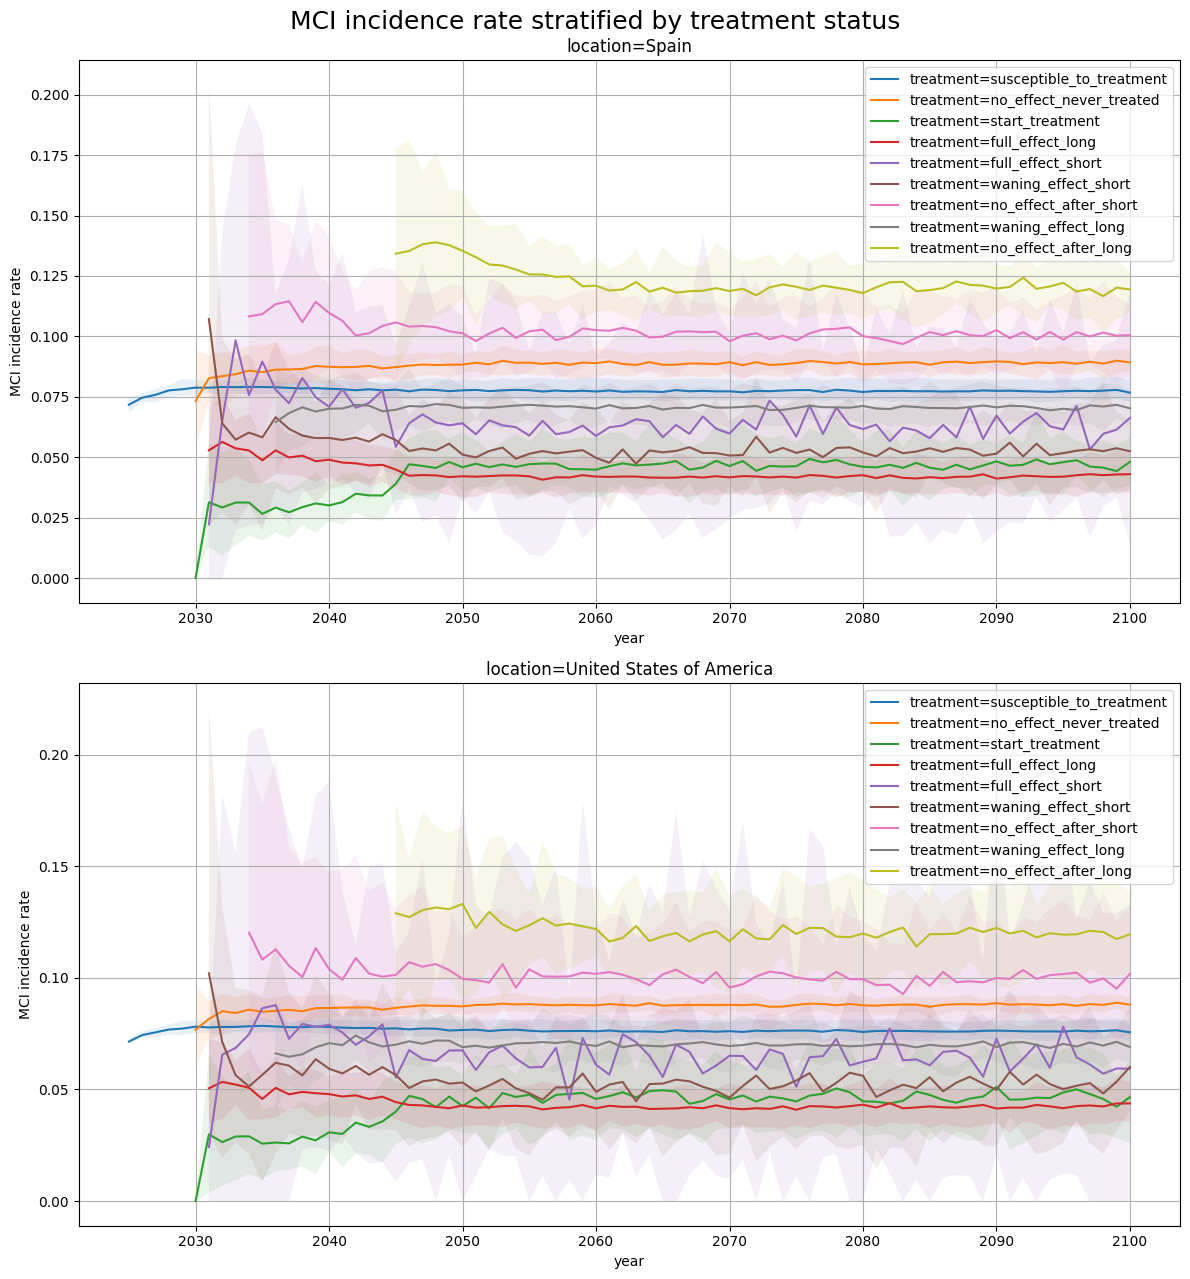

In [81]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    incidence_rates_by_treatment.loc[~inf].query("from_state=='alzheimers_blood_based_biomarker_state'"),
    'treatment',
    'location',
    ylabel='MCI incidence rate',
    suptitle='MCI incidence rate stratified by treatment status',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

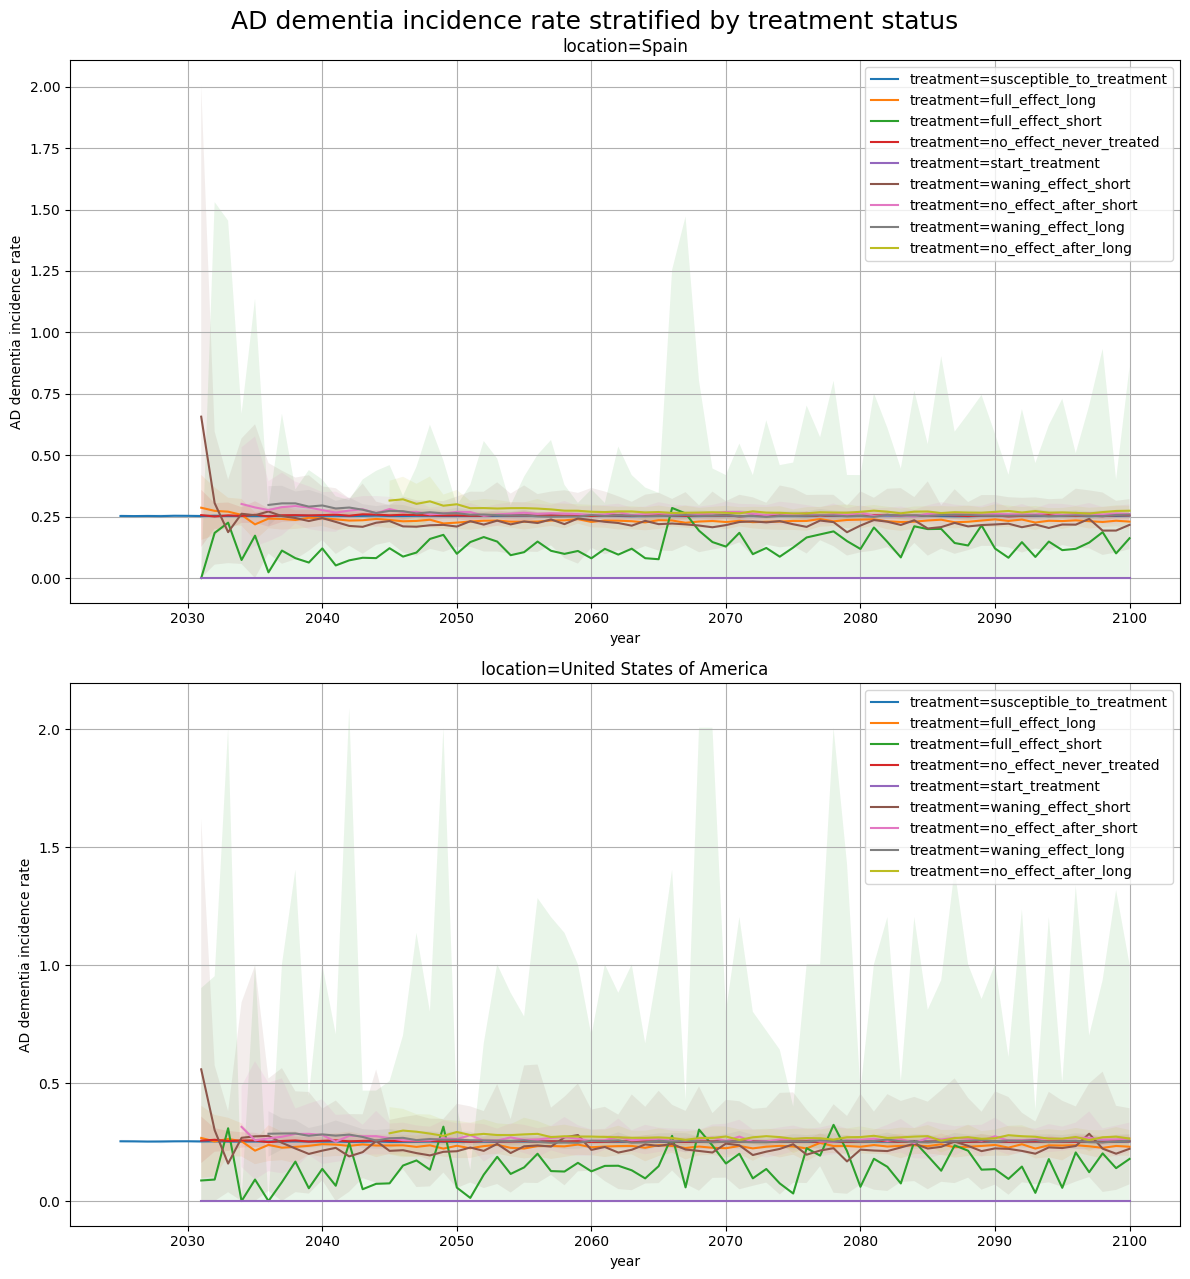

In [82]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    incidence_rates_by_treatment.loc[~inf].query("from_state=='alzheimers_mild_cognitive_impairment_state'"),
    'treatment',
    'location',
    ylabel='AD dementia incidence rate',
    suptitle='AD dementia incidence rate stratified by treatment status',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

# Results!

# Load deaths and plot averted deaths by scenario

In [83]:
deaths = load_sim_output('deaths')
print_memory_usage(deaths)
deaths

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/spain.hdf'])
13.000973 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
683995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
683996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
683997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
683998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
683999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                          entity entity_type  event_year input_draw measure  \
0       alzheimers_disease_state       cause        2025        113  deaths   
1       alzheimers_disease_state       cause        2025        113  deaths   
2       alzheimers_disease_state       cause        2025        113  deaths   
3       alzheimers_disease_state       cause        2025        113  deaths   
4       alzheimers_disease_state       cause        2025        113  deaths   
...                          ...         ...         ...        ...     ...   
683995              other_causes       cause        2100        457  deaths   
683996              other_causes       cause        2100        457  deaths   
683997              other_causes       cause        2100        457  deaths   
683998              other_causes       cause        2100        457  deaths   
683999              other_causes       cause        2100        457  deaths   

                          scenario     sex   value                  location  
0                         baseline  Female     0.0                     Spain  
1                         baseline    Male     0.0                     Spain  
2                     bbbm_testing  Female     0.0                     Spain  
3                     bbbm_testing    Male     0.0                     Spain  
4       bbbm_testing_and_treatment  Female     0.0                     Spain  
...                            ...     ...     ...                       ...  
683995                    baseline    Male   660.0  United States of America  
683996                bbbm_testing  Female  1616.0  United States of America  
683997                bbbm_testing    Male   660.0  United States of America  
683998  bbbm_testing_and_treatment  Female  1627.0  United States of America  
683999  bbbm_testing_and_treatment    Male   666.0  United States of America  

[684000 rows x 11 columns]

In [84]:
# NOTE: I had to rework some code in my vph_output.operators.difference
# function to prevent this code from converting Categoricals back to
# strings and making the memory explode...
averted_deaths = ops.averted(deaths, baseline_scenario='baseline')
print_memory_usage(averted_deaths)
# convert_dtypes(averted_deaths, colname_to_dtype=colname_to_categorical_dtype, inplace=True)
# print_memory_usage(averted_deaths)
# convert_to_categorical(averted_deaths, inplace=True)
# print_memory_usage(averted_deaths)
averted_deaths

13.000973 MB measure
6.160841 MB minuend
12.316841 MB subtrahend
4.112129 MB minuend re-indexed
8.216129 MB subtrahend re-indexed
8.216189 MB difference
11.404973 MB difference with reset index
11.861298 MB final difference
11.861298 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
455995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
455996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
455997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
455998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
455999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                          entity entity_type  event_year input_draw measure  \
0       alzheimers_disease_state       cause        2025        113  deaths   
1       alzheimers_disease_state       cause        2025        113  deaths   
2       alzheimers_disease_state       cause        2025        113  deaths   
3       alzheimers_disease_state       cause        2025        113  deaths   
4       alzheimers_disease_state       cause        2025        356  deaths   
...                          ...         ...         ...        ...     ...   
455995              other_causes       cause        2100        499  deaths   
455996              other_causes       cause        2100        457  deaths   
455997              other_causes       cause        2100        457  deaths   
455998              other_causes       cause        2100        457  deaths   
455999              other_causes       cause        2100        457  deaths   

           sex                  location                    scenario  \
0       Female                     Spain                bbbm_testing   
1         Male                     Spain                bbbm_testing   
2       Female                     Spain  bbbm_testing_and_treatment   
3         Male                     Spain  bbbm_testing_and_treatment   
4       Female                     Spain                bbbm_testing   
...        ...                       ...                         ...   
455995    Male  United States of America  bbbm_testing_and_treatment   
455996  Female  United States of America                bbbm_testing   
455997    Male  United States of America                bbbm_testing   
455998  Female  United States of America  bbbm_testing_and_treatment   
455999    Male  United States of America  bbbm_testing_and_treatment   

       subtracted_from  value  
0             baseline    0.0  
1             baseline    0.0  
2             baseline    0.0  
3             baseline    0.0  
4             baseline    0.0  
...                ...    ...  
455995        baseline   -5.0  
455996        baseline    0.0  
455997        baseline    0.0  
455998        baseline  -11.0  
455999        baseline   -6.0  

[456000 rows x 12 columns]

In [85]:
averted_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456000 entries, 0 to 455999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   age_group        456000 non-null  category
 1   artifact_path    456000 non-null  category
 2   entity           456000 non-null  category
 3   entity_type      456000 non-null  category
 4   event_year       456000 non-null  int64   
 5   input_draw       456000 non-null  category
 6   measure          456000 non-null  category
 7   sex              456000 non-null  category
 8   location         456000 non-null  category
 9   scenario         456000 non-null  category
 10  subtracted_from  456000 non-null  category
 11  value            456000 non-null  float64 
dtypes: category(10), float64(1), int64(1)
memory usage: 11.3 MB


In [86]:
averted_deaths['scenario'].dtype.categories

Index(['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment'], dtype='object')

In [87]:
averted_deaths.index.memory_usage(deep=True)

132

In [88]:
averted_deaths.entity.unique()

['alzheimers_disease_state', 'other_causes']
Categories (2, object): ['alzheimers_disease_state', 'other_causes']

In [89]:
averted_deaths.value.describe()

count    456000.000000
mean          0.063763
std           3.384657
min         -66.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          55.000000
Name: value, dtype: float64

In [90]:
# convert_dtypes(averted_deaths, colname_to_categorical_dtype, inplace=True)
# convert_to_categorical(averted_deaths, inplace=True)
print_memory_usage(averted_deaths)

11.861298 MB


In [91]:
# FIXME: Wait, to get percent deaths averted, do I want to be dividing
# by deaths in the intervention scenarios (like I do here), or should I
# be dividing by deaths in the *baseline* scenario? Probably the
# latter...
print_memory_usage(averted_deaths)
averted_deaths_pct = ops.ratio(
    averted_deaths,
    deaths.query("scenario != 'baseline'"),
    strata=['entity', 'age_group', 'event_year'],
    dropna=True, # Drop strata in younger age groups where we divided by 0
    multiplier=100,
)
print_memory_usage(averted_deaths_pct)
# convert_dtypes(averted_deaths_pct, colname_to_categorical_dtype, inplace=True)
# print_memory_usage(averted_deaths_pct)
# convert_to_categorical(averted_deaths_pct, inplace=True)
# print_memory_usage(averted_deaths_pct)
averted_deaths_pct

11.861298 MB
4.889731 MB


entity age_group  event_year input_draw  \
0       alzheimers_disease_state  40_to_44        2027        262   
1       alzheimers_disease_state  40_to_44        2027        262   
2       alzheimers_disease_state  40_to_44        2027        199   
3       alzheimers_disease_state  40_to_44        2027        199   
4       alzheimers_disease_state  40_to_44        2027        265   
...                          ...       ...         ...        ...   
157589              other_causes   95_plus        2100        499   
157590              other_causes   95_plus        2100        457   
157591              other_causes   95_plus        2100        457   
157592              other_causes   95_plus        2100        457   
157593              other_causes   95_plus        2100        457   

                          scenario                  location     value  \
0                     bbbm_testing                     Spain  0.000000   
1       bbbm_testing_and_treatment                     Spain  0.000000   
2                     bbbm_testing  United States of America  0.000000   
3       bbbm_testing_and_treatment  United States of America  0.000000   
4                     bbbm_testing                     Spain  0.000000   
...                            ...                       ...       ...   
157589  bbbm_testing_and_treatment  United States of America -1.038339   
157590                bbbm_testing                     Spain  0.000000   
157591                bbbm_testing  United States of America  0.000000   
157592  bbbm_testing_and_treatment                     Spain -1.416431   
157593  bbbm_testing_and_treatment  United States of America -0.741387   

       numerator_measure denominator_measure  multiplier  
0                 deaths              deaths         100  
1                 deaths              deaths         100  
2                 deaths              deaths         100  
3                 deaths              deaths         100  
4                 deaths              deaths         100  
...                  ...                 ...         ...  
157589            deaths              deaths         100  
157590            deaths              deaths         100  
157591            deaths              deaths         100  
157592            deaths              deaths         100  
157593            deaths              deaths         100  

[157594 rows x 10 columns]

In [92]:
averted_deaths_pct.memory_usage(deep=True)

Index                      132
entity                  157852
age_group               159124
event_year             1260752
input_draw              158350
scenario                157919
location                158568
value                  1260752
numerator_measure       157765
denominator_measure     157765
multiplier             1260752
dtype: int64

In [93]:
ops.stratify(averted_deaths, 'event_year')

event_year input_draw                    scenario  \
0           2025        113                bbbm_testing   
1           2025        113                bbbm_testing   
2           2025        113  bbbm_testing_and_treatment   
3           2025        113  bbbm_testing_and_treatment   
4           2025        356                bbbm_testing   
...          ...        ...                         ...   
7595        2100        499  bbbm_testing_and_treatment   
7596        2100        457                bbbm_testing   
7597        2100        457                bbbm_testing   
7598        2100        457  bbbm_testing_and_treatment   
7599        2100        457  bbbm_testing_and_treatment   

                      location  value  
0                        Spain    0.0  
1     United States of America    0.0  
2                        Spain    0.0  
3     United States of America    0.0  
4                        Spain    0.0  
...                        ...    ...  
7595  United States of America    4.0  
7596                     Spain    0.0  
7597  United States of America    0.0  
7598                     Spain    0.0  
7599  United States of America   -6.0  

[7600 rows x 5 columns]

In [94]:
# # FIXME: For some reason, this was taking a long time (>30 seconds before I interrupted it)
# averted_deaths_summary = summarize_sim_data(averted_deaths)
# averted_deaths_summary

In [95]:
def f(a=None, *args, **kwargs):
    print(a, args, kwargs)

f(1,2,3)
f(2)
f(5, b=4)
f(5, 6, b=7)
f()

1 (2, 3) {}
2 () {}
5 () {'b': 4}
5 (6,) {'b': 7}
None () {}


In [96]:
f(2)

2 () {}


# Draw results plots

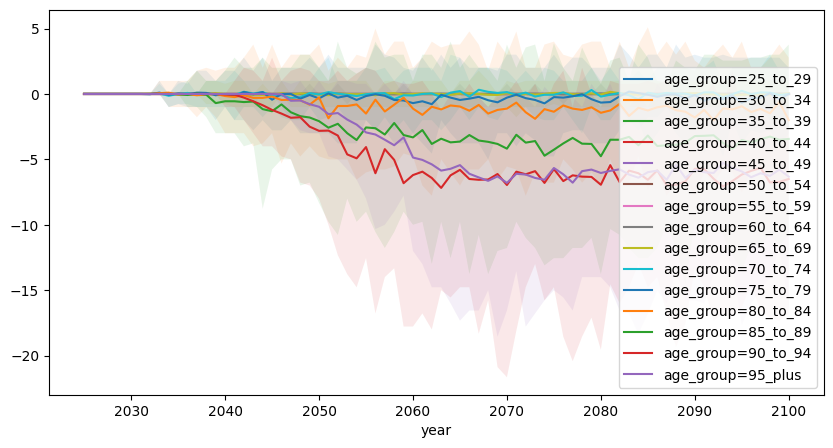

In [97]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(averted_deaths.query(
    "scenario == 'bbbm_testing_and_treatment' and entity == 'other_causes'"
    f" and location=={locations[0]!r}"
    ),
    'age_group'
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()


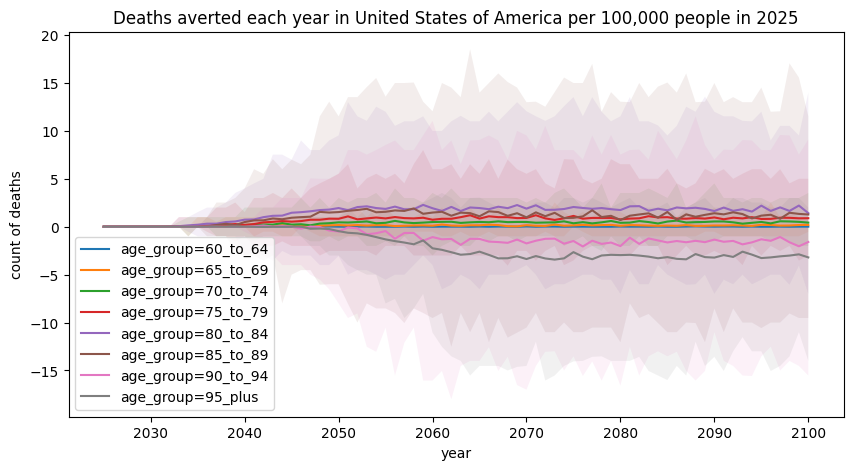

In [98]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment'" #and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="count of deaths",
    title=f"Deaths averted each year in {locations[0]} per 100,000 people in 2025"
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()

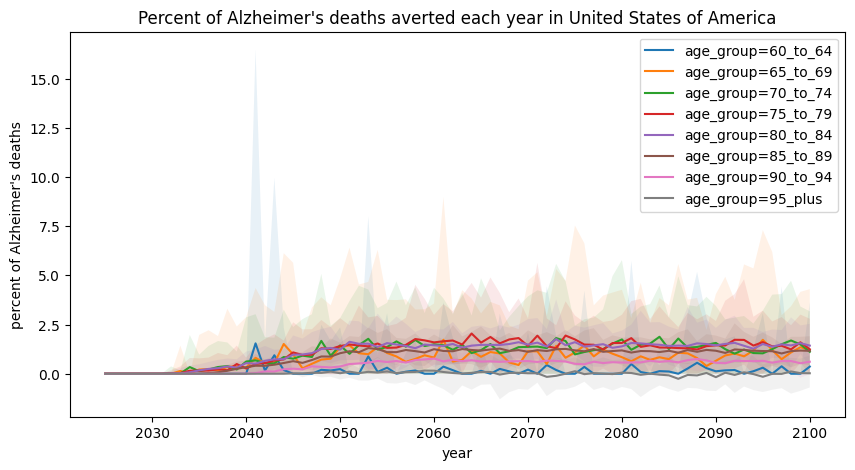

In [99]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="percent of Alzheimer's deaths",
    title=f"Percent of Alzheimer's deaths averted each year in {locations[0]}"
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()

In [100]:
deaths.scenario.unique()

['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

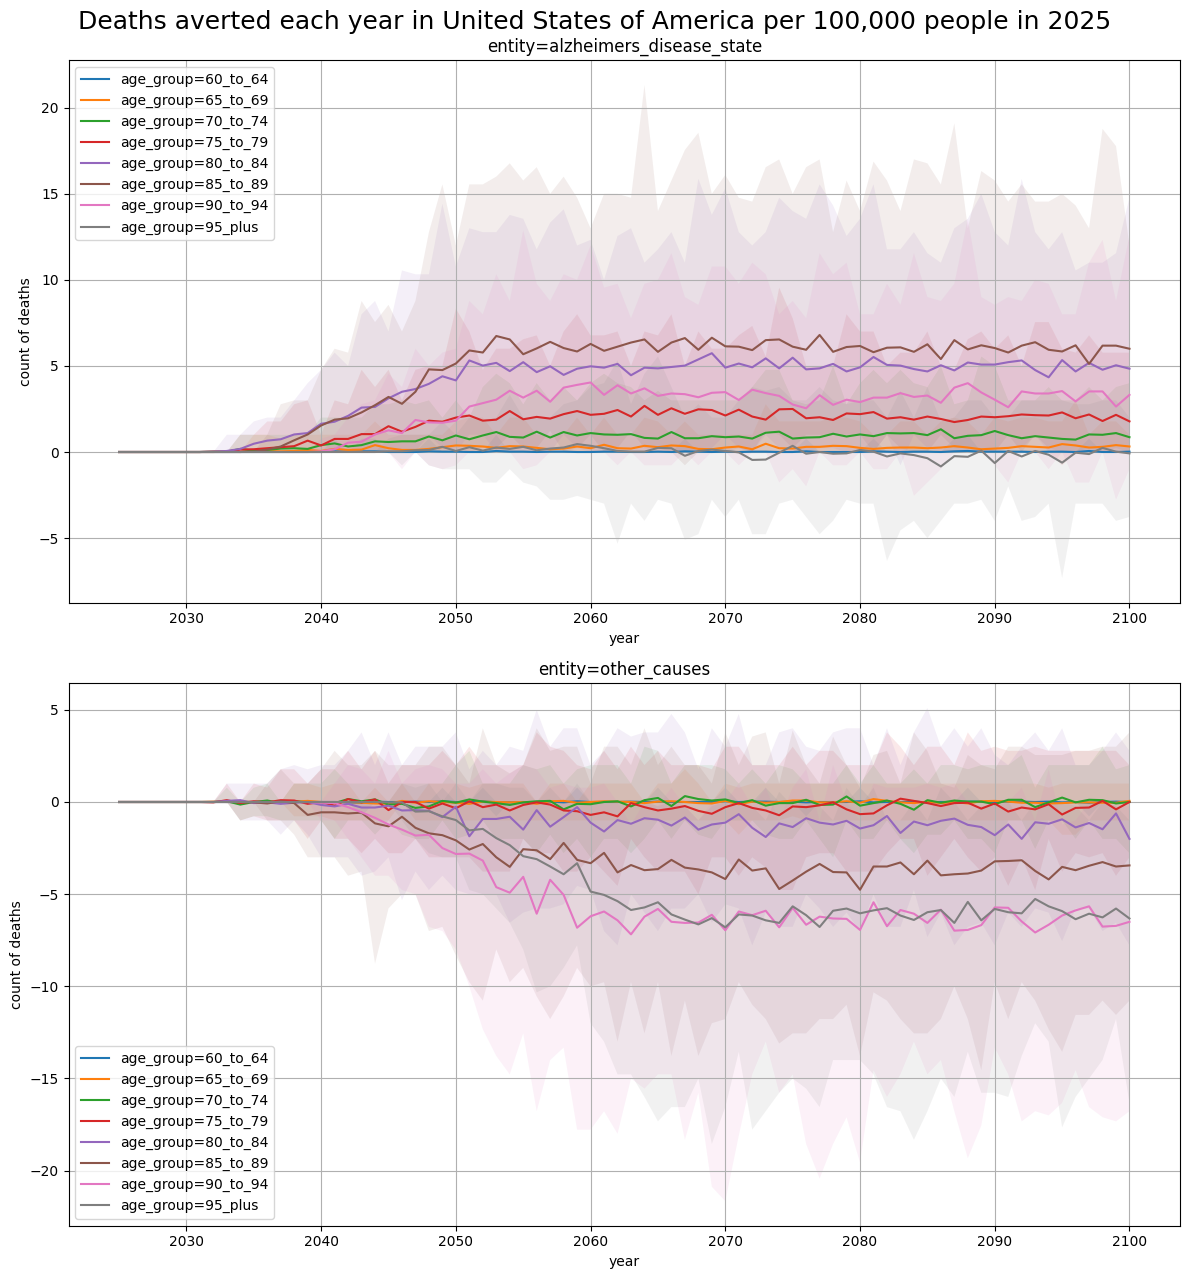

In [101]:
location = locations[0]
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and location==@location"
        ),
    'age_group',
    'entity',
    ylabel="count of deaths",
    suptitle=f"Deaths averted each year in {location} per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Absolute reductions in AD deaths for all countries

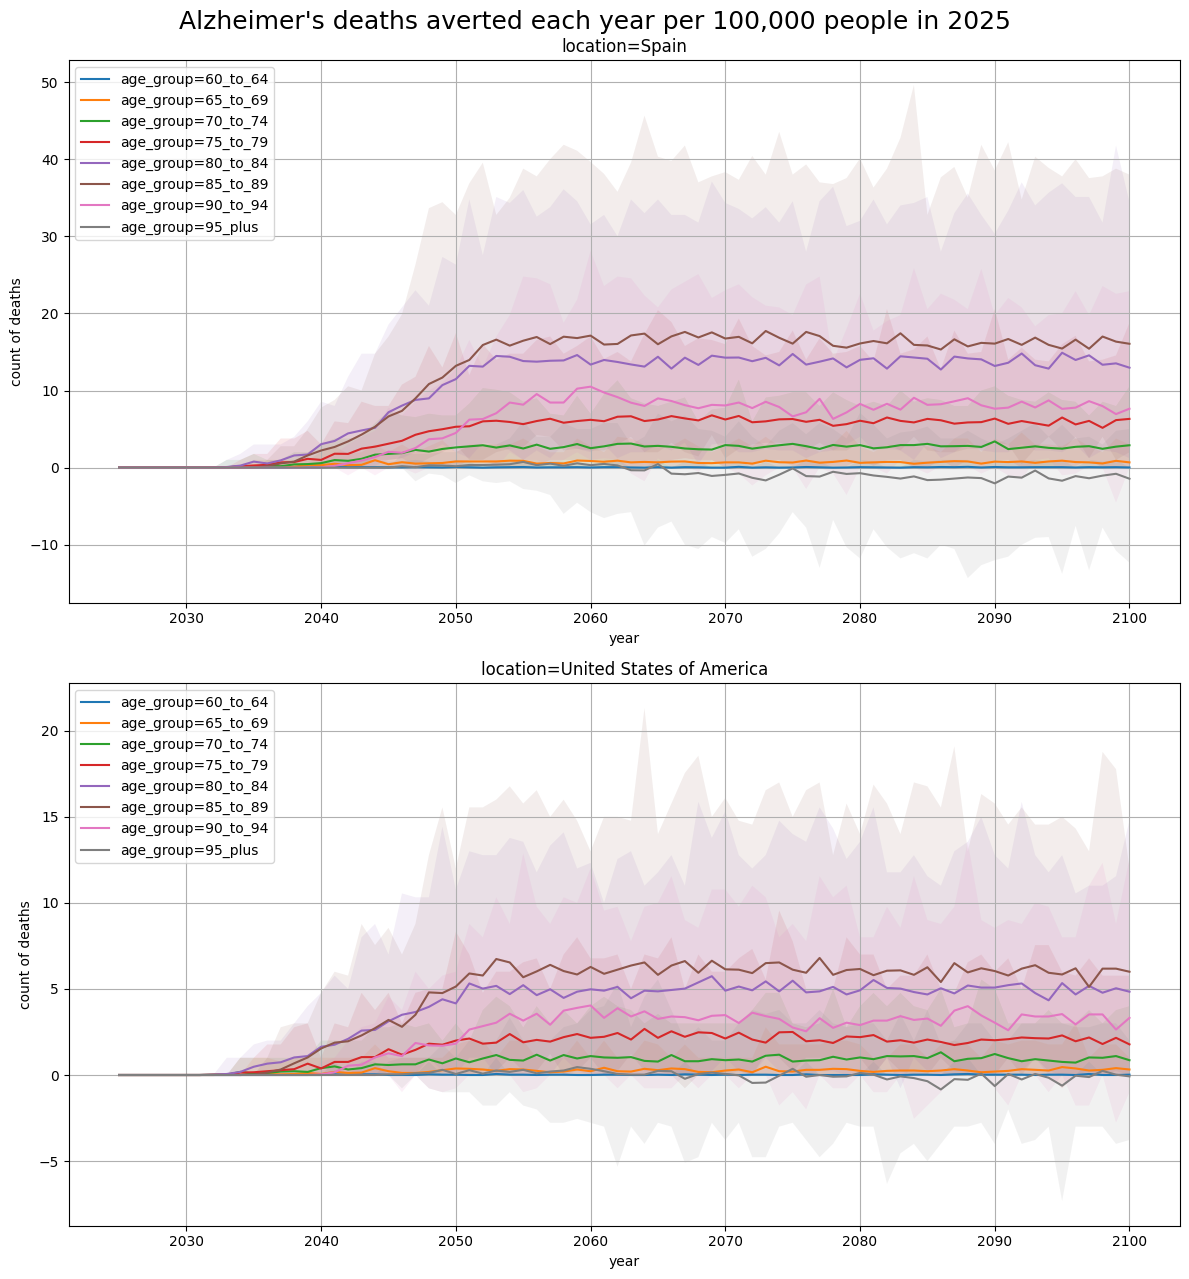

In [102]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="count of deaths",
    suptitle=f"Alzheimer's deaths averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Percent reductions in deaths for all countries

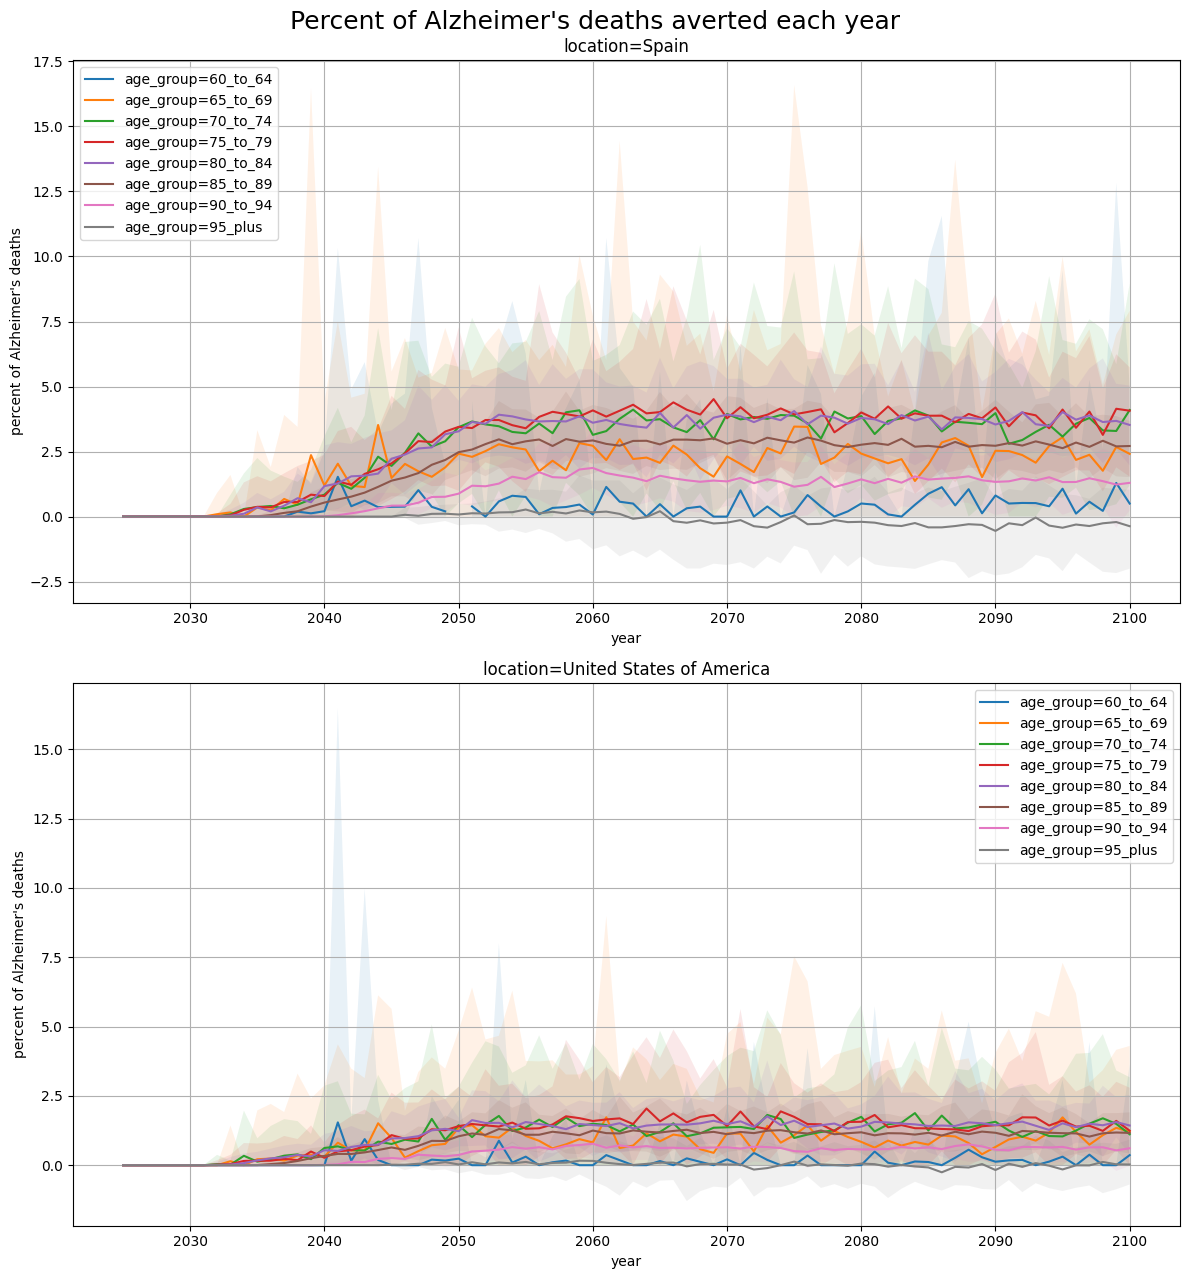

In [103]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="percent of Alzheimer's deaths",
    suptitle=f"Percent of Alzheimer's deaths averted each year"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Load YLLs and plot averted YLLs

In [104]:
ylls = load_sim_output('ylls')
print_memory_usage(ylls)
ylls

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/spain.hdf'])


13.000971 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
683995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
683996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
683997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
683998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
683999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                          entity entity_type  event_year input_draw measure  \
0       alzheimers_disease_state       cause        2025        113    ylls   
1       alzheimers_disease_state       cause        2025        113    ylls   
2       alzheimers_disease_state       cause        2025        113    ylls   
3       alzheimers_disease_state       cause        2025        113    ylls   
4       alzheimers_disease_state       cause        2025        113    ylls   
...                          ...         ...         ...        ...     ...   
683995              other_causes       cause        2100        457    ylls   
683996              other_causes       cause        2100        457    ylls   
683997              other_causes       cause        2100        457    ylls   
683998              other_causes       cause        2100        457    ylls   
683999              other_causes       cause        2100        457    ylls   

                          scenario     sex         value  \
0                         baseline  Female      0.000000   
1                         baseline    Male      0.000000   
2                     bbbm_testing  Female      0.000000   
3                     bbbm_testing    Male      0.000000   
4       bbbm_testing_and_treatment  Female      0.000000   
...                            ...     ...           ...   
683995                    baseline    Male   5380.962907   
683996                bbbm_testing  Female  13016.412718   
683997                bbbm_testing    Male   5380.962907   
683998  bbbm_testing_and_treatment  Female  13091.510686   
683999  bbbm_testing_and_treatment    Male   5426.392251   

                        location  
0                          Spain  
1                          Spain  
2                          Spain  
3                          Spain  
4                          Spain  
...                          ...  
683995  United States of America  
683996  United States of America  
683997  United States of America  
683998  United States of America  
683999  United States of America  

[684000 rows x 11 columns]

In [105]:
averted_ylls = ops.averted(ylls, baseline_scenario='baseline')
print_memory_usage(averted_ylls)

13.000971 MB measure
6.160839 MB minuend
12.316839 MB subtrahend
4.112127 MB minuend re-indexed
8.216127 MB subtrahend re-indexed
8.216187 MB difference
11.404971 MB difference with reset index
11.861296 MB final difference
11.861296 MB


In [106]:
averted_ylls.entity.unique()

['alzheimers_disease_state', 'other_causes']
Categories (2, object): ['alzheimers_disease_state', 'other_causes']

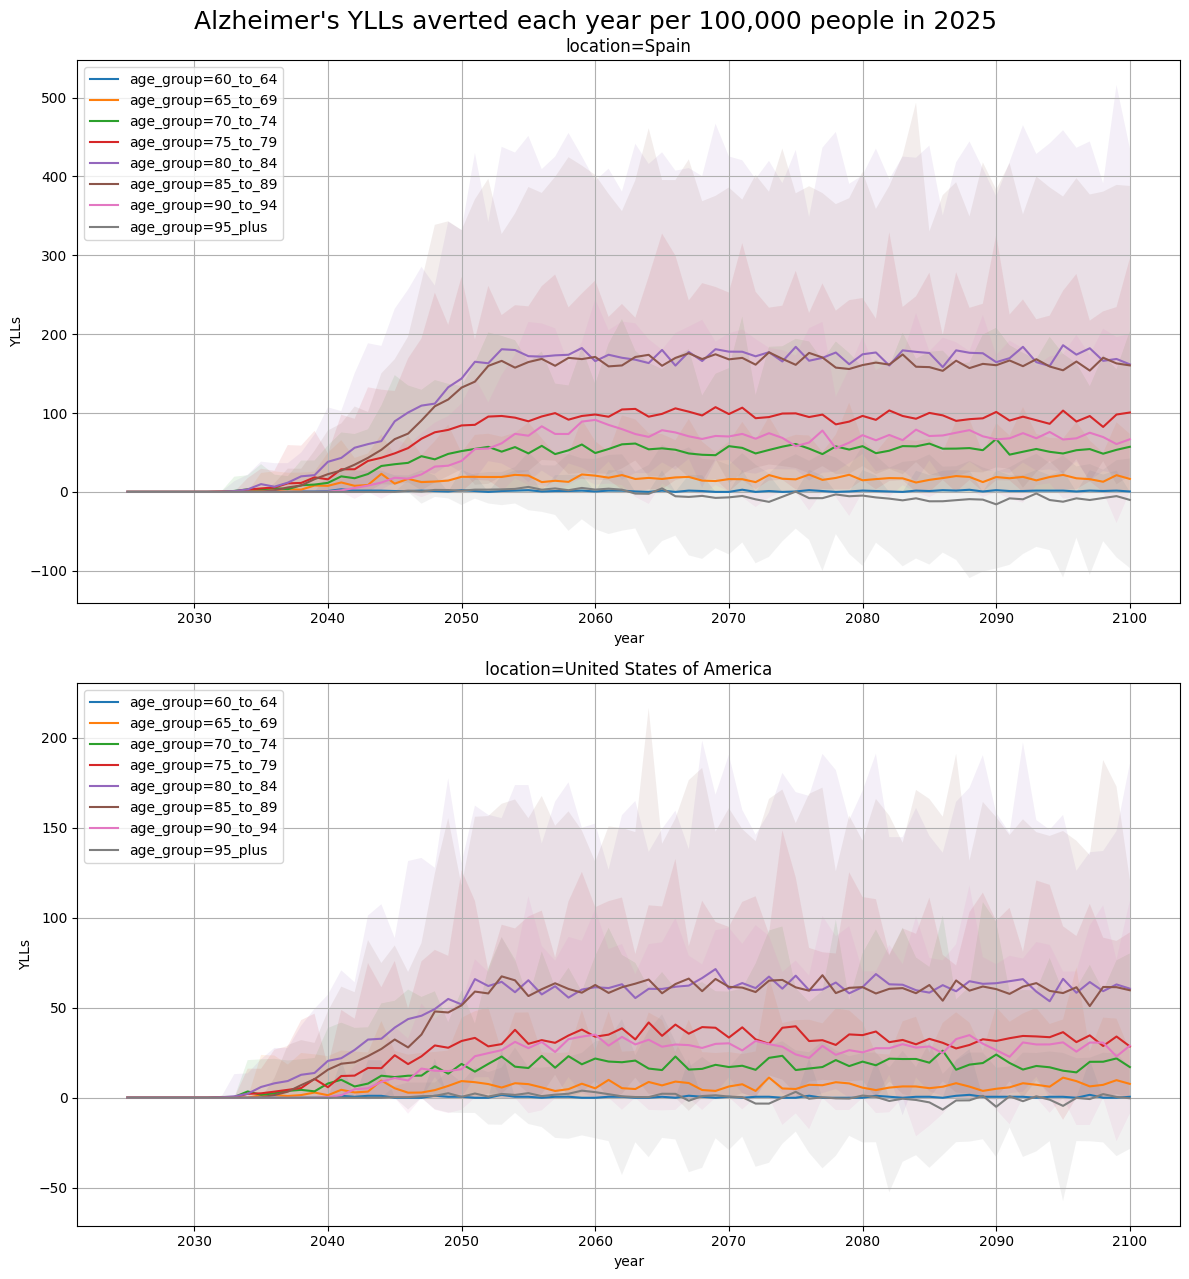

In [107]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="YLLs",
    suptitle=f"Alzheimer's YLLs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    ax.grid(True)
plt.show()

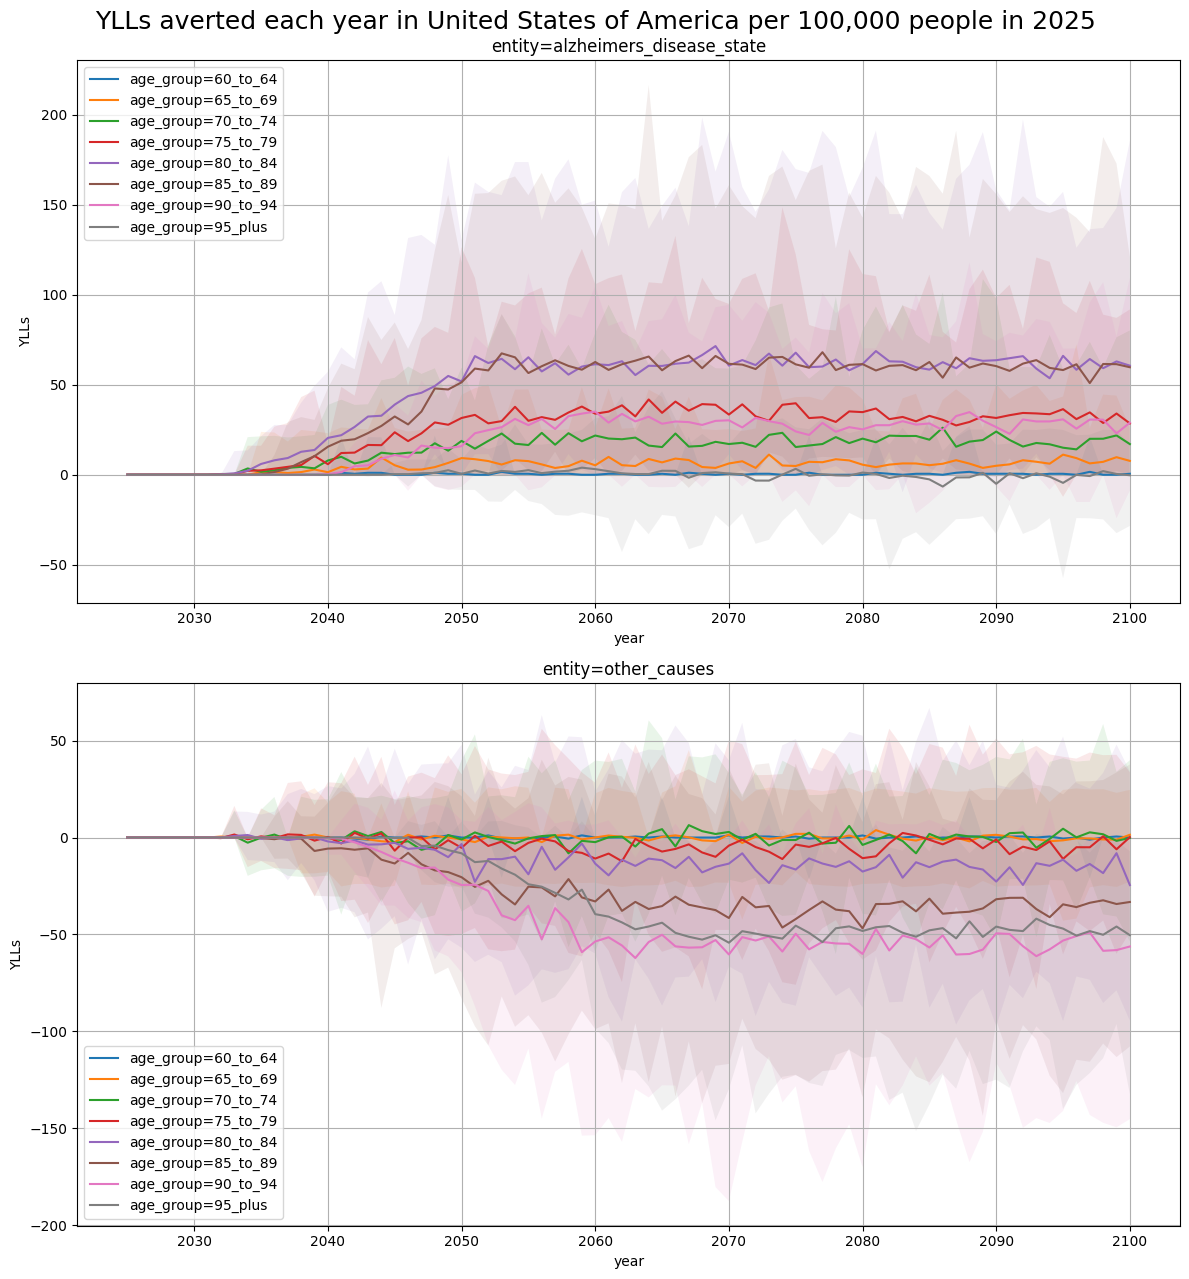

In [108]:
location = locations[0]
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and location==@location"
        ),
    'age_group',
    'entity',
    ylabel="YLLs",
    suptitle=f"YLLs averted each year in {location} per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

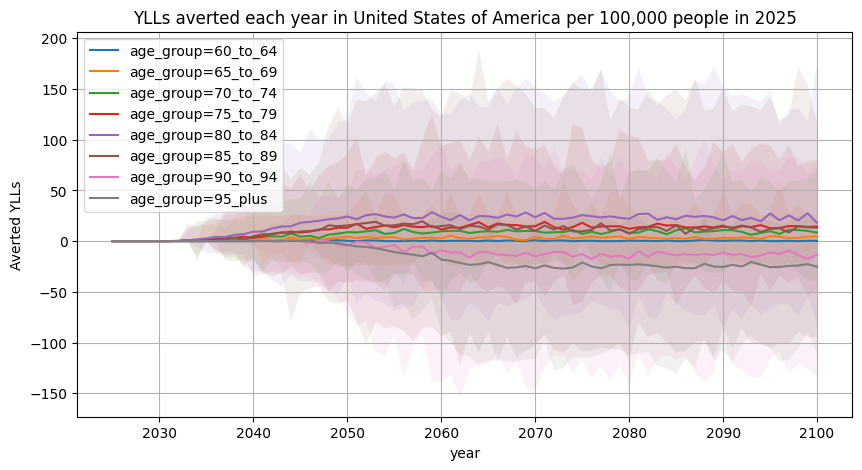

In [109]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment'" #and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="Averted YLLs",
    title=f"YLLs averted each year in {locations[0]} per 100,000 people in 2025"
)
# ax.set_xticks(ax.get_xticks()[::10])
ax.grid(True)
plt.show()

# Load YLDs and plot averted YLDs

In [110]:
ylds = load_sim_output('ylds')
print_memory_usage(ylds)
ylds

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/spain.hdf'])


82.086296 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
4103995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4103996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4103997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4103998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4103999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
0        alzheimers_disease_and_other_dementias       cause        2025   
1        alzheimers_disease_and_other_dementias       cause        2025   
2        alzheimers_disease_and_other_dementias       cause        2025   
3        alzheimers_disease_and_other_dementias       cause        2025   
4        alzheimers_disease_and_other_dementias       cause        2025   
...                                         ...         ...         ...   
4103995                              all_causes       cause        2100   
4103996                              all_causes       cause        2100   
4103997                              all_causes       cause        2100   
4103998                              all_causes       cause        2100   
4103999                              all_causes       cause        2100   

        input_draw measure                    scenario     sex  \
0              113    ylds                    baseline  Female   
1              113    ylds                    baseline  Female   
2              113    ylds                    baseline  Female   
3              113    ylds                    baseline    Male   
4              113    ylds                    baseline    Male   
...            ...     ...                         ...     ...   
4103995        457    ylds                    baseline    Male   
4103996        457    ylds                bbbm_testing  Female   
4103997        457    ylds                bbbm_testing    Male   
4103998        457    ylds  bbbm_testing_and_treatment  Female   
4103999        457    ylds  bbbm_testing_and_treatment    Male   

                                         sub_entity        value  \
0            alzheimers_blood_based_biomarker_state     0.000000   
1        alzheimers_mild_cognitive_impairment_state     0.010383   
2                          alzheimers_disease_state     0.000000   
3            alzheimers_blood_based_biomarker_state     0.000000   
4        alzheimers_mild_cognitive_impairment_state     0.000000   
...                                             ...          ...   
4103995                                  all_causes   590.202279   
4103996                                  all_causes  1864.945068   
4103997                                  all_causes   590.202279   
4103998                                  all_causes  1864.061987   
4103999                                  all_causes   589.402166   

                         location  
0                           Spain  
1                           Spain  
2                           Spain  
3                           Spain  
4                           Spain  
...                           ...  
4103995  United States of America  
4103996  United States of America  
4103997  United States of America  
4103998  United States of America  
4103999  United States of America  

[4104000 rows x 12 columns]

In [111]:
averted_ylds = ops.averted(ylds, baseline_scenario='baseline')
print_memory_usage(averted_ylds)
# This converts years from int64 to int16
convert_dtypes(averted_ylds, colname_to_dtype, inplace=True)
print_memory_usage(averted_ylds)
# This would convert integer years to Categorical
# convert_to_categorical(averted_ylds, inplace=True)
# print_memory_usage(averted_ylds)

82.086296 MB measure
38.310164 MB minuend
76.614164 MB subtrahend
26.001524 MB minuend re-indexed
51.993524 MB subtrahend re-indexed
51.993584 MB difference
71.142296 MB difference with reset index
73.878621 MB final difference
73.878621 MB
57.462621 MB


In [112]:
1086.443257 / 27.372526

39.69101196579373

In [113]:
averted_ylds.memory_usage(deep=True)

Index                   132
age_group           2737530
artifact_path       2736425
entity              2736336
entity_type         2736170
event_year          5472000
input_draw          2736756
measure             2736169
sex                 2736232
sub_entity          2737247
location            2736974
scenario            2736325
subtracted_from     2736325
value              21888000
dtype: int64

In [114]:
averted_ylds.dtypes

age_group          category
artifact_path      category
entity             category
entity_type        category
event_year            int16
input_draw         category
measure            category
sex                category
sub_entity         category
location           category
scenario           category
subtracted_from    category
value               float64
dtype: object

In [115]:
averted_ylds

age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
2735995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2735996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2735997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2735998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2735999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
0        alzheimers_disease_and_other_dementias       cause        2025   
1        alzheimers_disease_and_other_dementias       cause        2025   
2        alzheimers_disease_and_other_dementias       cause        2025   
3        alzheimers_disease_and_other_dementias       cause        2025   
4        alzheimers_disease_and_other_dementias       cause        2025   
...                                         ...         ...         ...   
2735995                              all_causes       cause        2100   
2735996                              all_causes       cause        2100   
2735997                              all_causes       cause        2100   
2735998                              all_causes       cause        2100   
2735999                              all_causes       cause        2100   

        input_draw measure     sex  \
0              113    ylds  Female   
1              113    ylds  Female   
2              113    ylds  Female   
3              113    ylds    Male   
4              113    ylds    Male   
...            ...     ...     ...   
2735995        499    ylds    Male   
2735996        457    ylds  Female   
2735997        457    ylds    Male   
2735998        457    ylds  Female   
2735999        457    ylds    Male   

                                         sub_entity                  location  \
0            alzheimers_blood_based_biomarker_state                     Spain   
1        alzheimers_mild_cognitive_impairment_state                     Spain   
2                          alzheimers_disease_state                     Spain   
3            alzheimers_blood_based_biomarker_state                     Spain   
4        alzheimers_mild_cognitive_impairment_state                     Spain   
...                                             ...                       ...   
2735995                                  all_causes  United States of America   
2735996                                  all_causes  United States of America   
2735997                                  all_causes  United States of America   
2735998                                  all_causes  United States of America   
2735999                                  all_causes  United States of America   

                           scenario subtracted_from     value  
0                      bbbm_testing        baseline  0.000000  
1                      bbbm_testing        baseline  0.000000  
2                      bbbm_testing        baseline  0.000000  
3                      bbbm_testing        baseline  0.000000  
4                      bbbm_testing        baseline  0.000000  
...                             ...             ...       ...  
2735995  bbbm_testing_and_treatment        baseline -0.411510  
2735996                bbbm_testing        baseline  0.000000  
2735997                bbbm_testing        baseline  0.000000  
2735998  bbbm_testing_and_treatment        baseline  0.883082  
2735999  bbbm_testing_and_treatment        baseline  0.800113  

[2736000 rows x 13 columns]

In [116]:
averted_ylds.entity.unique()

['alzheimers_disease_and_other_dementias', 'treatment', 'all_causes']
Categories (3, object): ['all_causes', 'alzheimers_disease_and_other_dementias', 'treatment']

In [117]:
# All values are 0 in this sub-dataframe
averted_ylds.query("entity=='treatment'")

age_group                                      artifact_path  \
22800    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
22801    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
22802    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
22803    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
22804    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
2728395   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2728396   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2728397   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2728398   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2728399   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw measure     sex  \
22800    treatment       cause        2025        113    ylds  Female   
22801    treatment       cause        2025        113    ylds  Female   
22802    treatment       cause        2025        113    ylds  Female   
22803    treatment       cause        2025        113    ylds  Female   
22804    treatment       cause        2025        113    ylds  Female   
...            ...         ...         ...        ...     ...     ...   
2728395  treatment       cause        2100        457    ylds    Male   
2728396  treatment       cause        2100        457    ylds    Male   
2728397  treatment       cause        2100        457    ylds    Male   
2728398  treatment       cause        2100        457    ylds    Male   
2728399  treatment       cause        2100        457    ylds    Male   

                      sub_entity                  location  \
22800            start_treatment                     Spain   
22801           full_effect_long                     Spain   
22802          full_effect_short                     Spain   
22803         waning_effect_long                     Spain   
22804        waning_effect_short                     Spain   
...                          ...                       ...   
2728395       waning_effect_long  United States of America   
2728396      waning_effect_short  United States of America   
2728397     no_effect_after_long  United States of America   
2728398    no_effect_after_short  United States of America   
2728399  no_effect_never_treated  United States of America   

                           scenario subtracted_from  value  
22800                  bbbm_testing        baseline    0.0  
22801                  bbbm_testing        baseline    0.0  
22802                  bbbm_testing        baseline    0.0  
22803                  bbbm_testing        baseline    0.0  
22804                  bbbm_testing        baseline    0.0  
...                             ...             ...    ...  
2728395  bbbm_testing_and_treatment        baseline    0.0  
2728396  bbbm_testing_and_treatment        baseline    0.0  
2728397  bbbm_testing_and_treatment        baseline    0.0  
2728398  bbbm_testing_and_treatment        baseline    0.0  
2728399  bbbm_testing_and_treatment        baseline    0.0  

[1824000 rows x 13 columns]

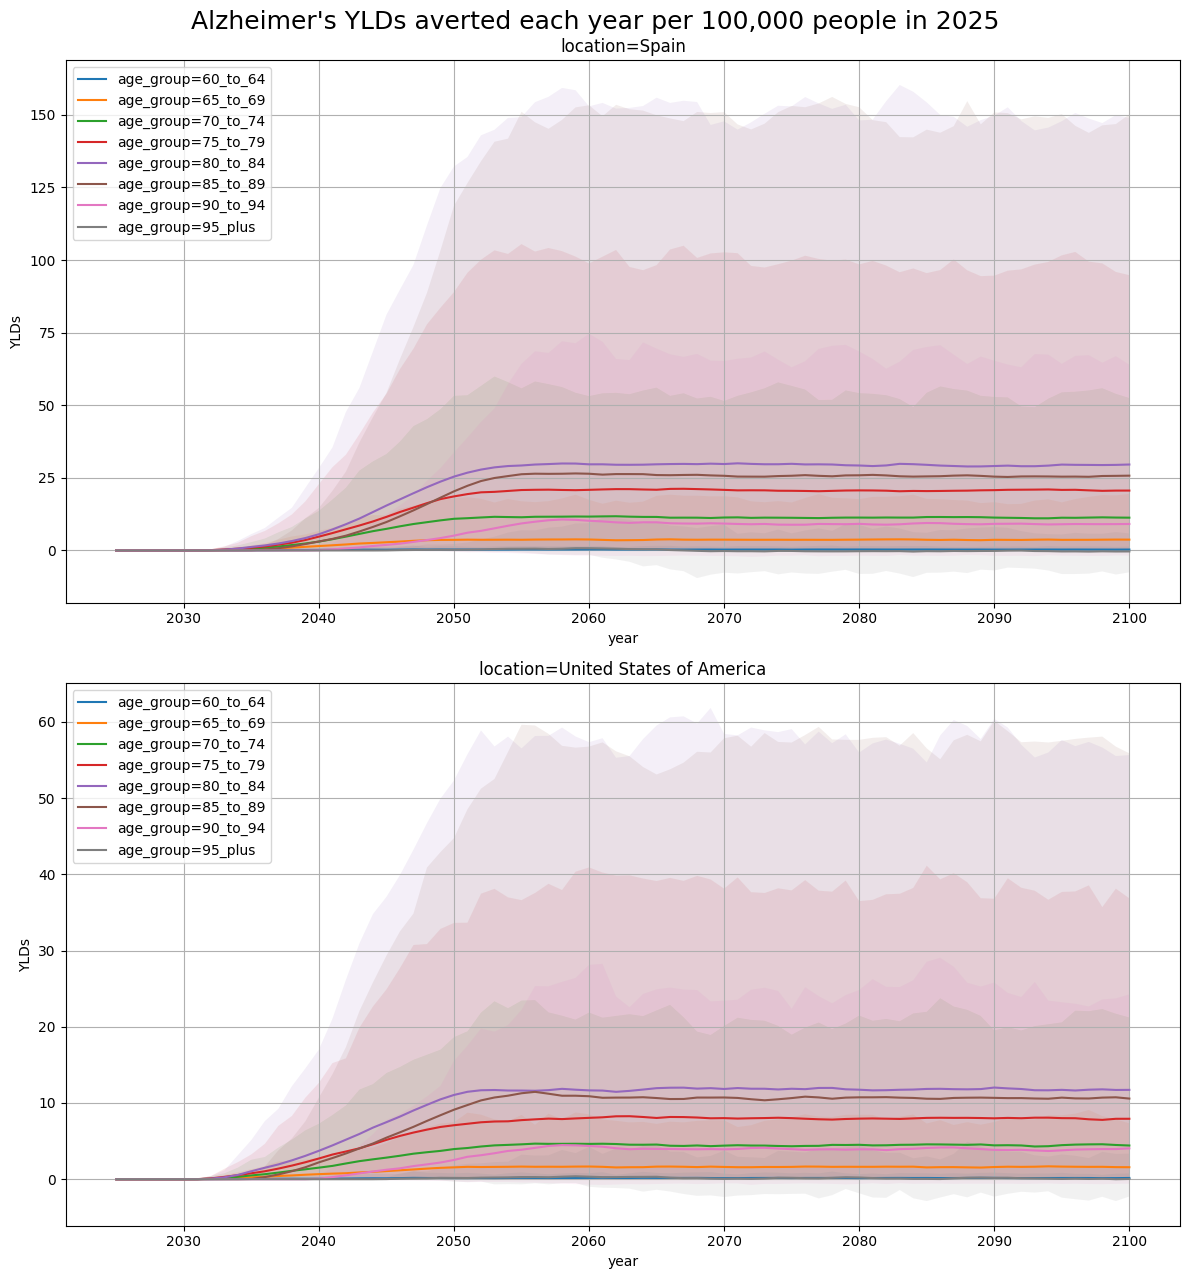

In [118]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylds
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_and_other_dementias'"
        ),
    'age_group',
    'location',
    ylabel="YLDs",
    suptitle=f"Alzheimer's YLDs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

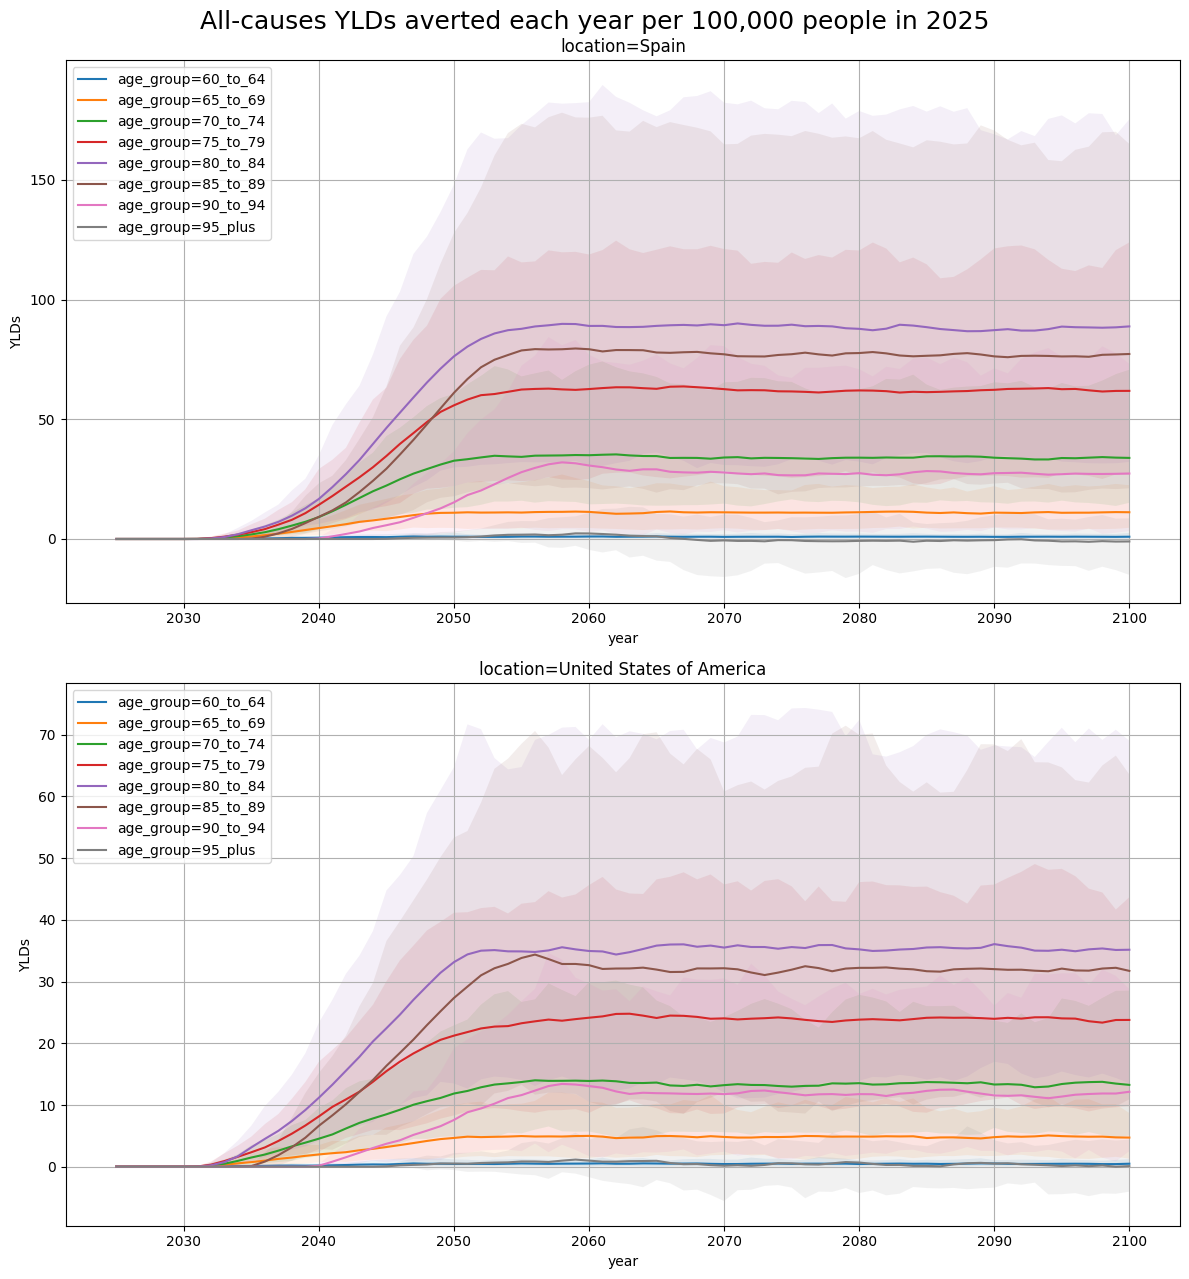

In [119]:
# I'm not sure why total YLDs averted is greater than Alzheimer's YLDs
# averted...
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylds
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'all_causes'"
        ),
    'age_group',
    'location',
    ylabel="YLDs",
    suptitle=f"All-causes YLDs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()